In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os
import anndata as ad
from cyvcf2 import VCF
from tqdm import tqdm
from scipy import stats
from functools import partial

## Expression data

In [2]:
file = '/home/e860a/chernova/onek1k/norm/onek1k.norm_pflogpf.h5ad'

In [3]:
data = ad.read_h5ad(file)

In total 982 individuals:

In [5]:
np.unique(data[data.obs.old_cell_label=='CD4 NC'].obs.pheno_id).shape

(982,)

In [6]:
data.var.head()

GeneSymbol       features
Geneid                                       
ENSG00000243485     MIR1302-10     MIR1302-10
ENSG00000237613        FAM138A        FAM138A
ENSG00000186092          OR4F5          OR4F5
ENSG00000238009   RP11-34P13.7   RP11-34P13.7
ENSG00000239945   RP11-34P13.8   RP11-34P13.8

----
32K genes, ca 1M cells

In [7]:
data.obs.shape

(1264829, 18)

In [8]:
data.var.shape

(32738, 2)

## eQTL data

In [28]:
eqtl = pd.read_csv('/home/e860a/chernova/eQTLs.csv')

In [118]:
eqtl.head()

Cell type        Gene ID  Gene Ensembl ID         SNP  Chromosome  \
0      B IN  RP11-298J20.3  ENSG00000226899   rs4962711          10   
1      B IN           PPA1  ENSG00000180817  rs12355080          10   
2      B IN           GDI2  ENSG00000057608   rs3736461          10   
3      B IN           OPTN  ENSG00000123240  rs57057378          10   
4      B IN           MGMT  ENSG00000170430  rs12254582          10   

    Position SNP assessed allele eSNP rank  rho correlation coefficient  \
0  126644482                   C     eSNP1                       -0.473   
1   71963608                   A     eSNP1                        0.428   
2    5855403                   C     eSNP1                       -0.278   
3   13160035                   A     eSNP1                       -0.258   
4  131279791                   G     eSNP1                       -0.220   

   S-statistics        pvalue        qvalue       FDR ref_samples  \
0  2.324188e+08  8.650000e-56  5.110000e-50  0.000022           0   
1  9.033813e+07  6.310000e-45  1.650000e-40  0.000022           0   
2  2.017159e+08  6.760000e-19  6.080000e-15  0.000022           0   
3  1.984947e+08  2.340000e-16  2.030000e-12  0.000022           0   
4  1.925261e+08  3.260000e-12  2.150000e-08  0.000022           0   

  hom_ref_samples het_samples hom_alt_samples  
0               0           0               0  
1               0           0               0  
2               0           0               0  
3               0           0               0  
4               0           0               0

In [51]:
eqtl.shape

(26597, 13)

## Genotype data

### Combine eSNPs and patients in the same dataframe

In [11]:
def array_to_string(a):
    return ','.join(a.astype(str).tolist())

In [12]:
folder = '/omics/groups/OE0540/internal/users/senacheribbe/work/rarevar/data/onek1k/genotype/filter_vcf_r08/'

In [112]:
eqtl['hom_ref_samples'] = '0'
eqtl['het_samples'] = '0'
eqtl['hom_alt_samples'] = '0'

In [159]:
for chrom in np.unique(eqtl['Chromosome']):
    # iterate through chromosomes, since each has its own vcf file
    fname = f'chr{chrom}.dose.filtered.R2_0.8.vcf.gz'
    vcf_file = VCF(os.path.join(folder,fname))
    samples = np.array(vcf_file.samples)
    
    for i in eqtl[eqtl['Chromosome']==chrom].index.values:
        # iterate through all eSNPs on the chrom
        position = eqtl.loc[i, 'Position']
        snp = eqtl.loc[i, 'SNP assessed allele']
    
        for var in vcf_file(f'{chrom}:{position}-{position}'):
            
            if len(var.ALT) > 1:
                raise Exception(f'2+ alternative alleles (same entry): {chrom}, {position}')
                
            if var.ALT[0] == snp: # There are SNPs at the same position but different alternative allele -> seen as different eQTLs
                eqtl.loc[i, 'hom_ref_samples'] = array_to_string(samples[np.where(var.gt_types==0)])
                eqtl.loc[i, 'het_samples'] = array_to_string(samples[np.where(var.gt_types==1)])
                eqtl.loc[i, 'hom_alt_samples'] = array_to_string(samples[np.where(var.gt_types==3)])

In [161]:
eqtl.to_csv('/home/e860a/chernova/my_onek1k_data/eQTLs_patients.csv')

### Get the differences in expression between the means

- same gene, same eSNP, same cell type
- sample all patients in groups by genotype

In [5]:
eqtl = pd.read_csv('/home/e860a/chernova/my_onek1k_data/eQTLs_patients.csv')

In [6]:
eqtl.head()

Unnamed: 0 Cell type        Gene ID  Gene Ensembl ID         SNP  \
0           0      B IN  RP11-298J20.3  ENSG00000226899   rs4962711   
1           1      B IN           PPA1  ENSG00000180817  rs12355080   
2           2      B IN           GDI2  ENSG00000057608   rs3736461   
3           3      B IN           OPTN  ENSG00000123240  rs57057378   
4           4      B IN           MGMT  ENSG00000170430  rs12254582   

   Chromosome   Position SNP assessed allele eSNP rank  \
0          10  126644482                   C     eSNP1   
1          10   71963608                   A     eSNP1   
2          10    5855403                   C     eSNP1   
3          10   13160035                   A     eSNP1   
4          10  131279791                   G     eSNP1   

   rho correlation coefficient  S-statistics        pvalue        qvalue  \
0                       -0.473  2.324188e+08  8.650000e-56  5.110000e-50   
1                        0.428  9.033813e+07  6.310000e-45  1.650000e-40   
2                       -0.278  2.017159e+08  6.760000e-19  6.080000e-15   
3                       -0.258  1.984947e+08  2.340000e-16  2.030000e-12   
4                       -0.220  1.925261e+08  3.260000e-12  2.150000e-08   

        FDR  ref_samples                                    hom_ref_samples  \
0  0.000022            0  12_12,15_15,40_40,69_69,84_84,89_89,91_91,103_...   
1  0.000022            0  1_1,4_4,7_7,8_8,10_10,15_15,17_17,18_18,21_21,...   
2  0.000022            0  1_1,3_3,4_4,7_7,8_8,9_9,12_12,13_13,14_14,18_1...   
3  0.000022            0  2_2,3_3,4_4,6_6,10_10,12_12,13_13,14_14,18_18,...   
4  0.000022            0  6_6,8_8,9_9,10_10,11_11,14_14,15_15,16_16,17_1...   

                                         het_samples  \
0  8_8,23_23,24_24,27_27,28_28,30_30,32_32,33_33,...   
1  3_3,6_6,11_11,12_12,13_13,16_16,19_19,20_20,23...   
2  2_2,10_10,11_11,15_15,16_16,17_17,21_21,28_28,...   
3  1_1,9_9,11_11,15_15,16_16,17_17,20_20,26_26,27...   
4  1_1,2_2,4_4,21_21,26_26,29_29,32_32,35_35,38_3...   

                                     hom_alt_samples  
0  1_1,2_2,3_3,4_4,6_6,7_7,9_9,10_10,11_11,13_13,...  
1  2_2,9_9,14_14,25_25,34_34,36_36,47_47,57_57,68...  
2  6_6,27_27,36_36,45_45,61_61,78_78,242_243,263_...  
3  7_7,8_8,21_21,23_23,25_25,34_34,35_35,39_39,40...  
4  3_3,7_7,12_12,13_13,28_28,33_33,44_44,56_56,62...

Calculate t-statistics (comparing genotypes) -> submitted as job (src/get_t_vals.py)

In [89]:
# t_vals = np.zeros((3, eqtl.shape[0])) # number of classes (hom_ref, het, hom_alt), number of SNPs
# colnames = ['hom_ref_samples', 'het_samples', 'hom_alt_samples']
# for snp in tqdm(range(eqtl.shape[0])):
#     ok = True
#     expr_list = []
#     for col in [0, 2]:
#         search_str = eqtl.loc[snp, colnames[col]] # Select the string with the right patients
#         if type(search_str)==str:
#             search_str = search_str.replace(',', '|') # Transform to regex

#             gene = eqtl.loc[snp, 'Gene Ensembl ID']
#             cell_type = eqtl.loc[snp, 'Cell type']

#             mask = np.logical_and(data.obs.individual.str.contains(search_str, regex=True),
#                                   data.obs['old_cell_label']==cell_type)

#             x = data[mask, gene].X.copy().todense()
#             expr_list.append(x)
             
#         else:
#             ok = False
#             print(f'Not a string at row {snp}, column {col}')
        
        
#     if ok:
#         test = stats.ttest_ind(expr_list[0], expr_list[1])
#         t_vals[0, snp] = test.statistic
#         t_vals[1, snp] = test.pvalue
        #t_vals[2, snp] = expr[0].shape+expr[1].shape

### Analysis of obtained t values

In [7]:
tval_data = np.load('/home/e860a/chernova/my_onek1k_data/distances_tests/tvals_homref_homalt.npz')
tval_data.files

['tvals', 'pvalue', 'df']

In [8]:
tvals = tval_data['tvals']
pvals = tval_data['pvalue']
dfs = tval_data['df']

<Axes: >

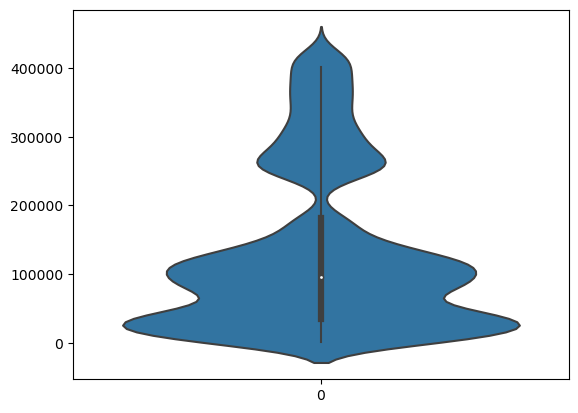

In [9]:
sn.violinplot(dfs)

Text(0.5, 0, 't statistic')

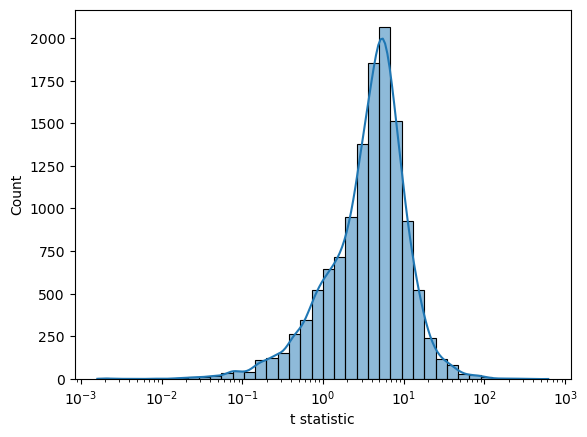

In [10]:
sn.histplot(tvals, bins=40, kde=True, log_scale=10)
plt.xlabel('t statistic')

There are 34 eQTLs, that have t-values above 100.

In [11]:
tvals[np.abs(tvals)>=100].shape

(34,)

Show the violin plots for these eQTLs:

In [13]:
fig, ax = plt.subplots(7, 5)
fig.set_size_inches(20, 15)

selected_snps = np.where(np.abs(tvals)>=100)

colnames = ['hom_ref_samples', 'het_samples', 'hom_alt_samples']
for count, i in tqdm(enumerate(selected_snps[0])):
    snp = eqtl.index.values[i]
    expr_list = []
    class_list = []
    for col in [0, 2]:
        search_str = eqtl.loc[snp, colnames[col]] # Select the string with the right patients
        if type(search_str)==str:
            search_str = search_str.replace(',', '|') # Transform to regex

            gene = eqtl.loc[snp, 'Gene Ensembl ID']
            cell_type = eqtl.loc[snp, 'Cell type']

            mask = np.logical_and(data.obs.individual.str.contains(search_str, regex=True),
                                  data.obs['old_cell_label']==cell_type)

            x = data[mask, gene].to_df().to_numpy()
            expr_list.append(x.flatten())
            class_list.extend([colnames[col] for i in range(x.shape[0])])
    
    gene_name = eqtl.loc[snp, 'Gene ID']
    df= pd.DataFrame({'Expression': np.concatenate(expr_list), 'Type': class_list})
    sn.violinplot(df, x='Type', y='Expression', ax=ax.reshape(-1)[count])
    ax.reshape(-1)[count].set_title(f'{gene_name} ({gene})')
plt.tight_layout()

Summarize the eQTLs with top t-statistic values by cell type and gene.

In [15]:
names = {}
tot_count = {}
for i in selected_snps[0]:
    snp = eqtl.index.values[i]
    gene_name = eqtl.loc[snp, 'Gene ID']
    cell = eqtl.loc[snp, 'Cell type']
    if f'{gene_name}_{cell}' in names.keys():
        names[f'{gene_name}_{cell}'] += 1
    else:
        names[f'{gene_name}_{cell}'] = 1
    
    if gene_name in tot_count.keys():
        tot_count[gene_name] += 1
    else:
        tot_count[gene_name] = 1
        
g_names = []
c_names = []
counts = []
t_counts = []
for k in names.keys():
    g_names.append(k.split('_')[0])
    c_names.append(k.split('_')[1])
    counts.append(names[k])
    t_counts.append(tot_count[k.split('_')[0]])
df = pd.DataFrame({'Gene': g_names, 'Cell': c_names, 'Count': counts, 'Total_count': t_counts})
df.sort_values(['Total_count', 'Gene'], ascending=False)

Gene       Cell  Count  Total_count
0                RPS26       B IN      2           16
3                RPS26      B Mem      2           16
5                RPS26     CD4 NC      2           16
13               RPS26     CD4 ET      2           16
14               RPS26     CD8 NC      2           16
15               RPS26     CD8 ET      2           16
18               RPS26  CD8 S100B      1           16
19               RPS26     Mono C      1           16
21               RPS26         NK      2           16
11               HLA-B     CD4 NC      1            3
17               HLA-B     CD8 ET      1            3
23               HLA-B         NK      1            3
9              SCGB3A1     CD4 NC      2            2
20       RP11-1143G9.4     Mono C      2            2
2             HLA-DRB5       B IN      1            2
4             HLA-DRB5      B Mem      1            2
1             HLA-DQA2       B IN      1            2
16            HLA-DQA2     CD8 ET      1            2
10  XXbac-BPG299F13.17     CD4 NC      1            1
8                SNHG8     CD4 NC      1            1
7                SMDT1     CD4 NC      1            1
12           PSMD5-AS1     CD4 NC      1            1
24               MYOM2         NK      1            1
22                GNLY         NK      1            1
6                EIF5A     CD4 NC      1            1

- **RPS26**: ribosomal protein S26 (40S ribosomal subunit)
- **HLA-B**: MHC I
- **SCGB3A1**: secretoglobin family 3A member 1. Secreted cytokine-like protein. Inhibits cell growth in vitro.
- **RP11-1143G9.4**: novel transcript, antisense to LYZ
- **HLA-DRB5**: MHC II
- **HLA-DQA2**: MHC II
- **XXbac-BPG299F13.17**: novel transcript, antisense to HCG27
- **SNHG8**: small nucleolar RNA host gene 8 (lncRNA). identified as a key regulator of epstein-barr virus(EBV)-associated gastric cancer
- **SMDT1**: single-pass membrane protein with aspartate rich tail 1. Essential regulatory subunit of the mitochondrial calcium uniporter complex (uniplex), a complex that mediates calcium uptake into mitochondria. Required to bridge the calcium-sensing proteins MICU1 and MICU2 with the calcium-conducting subunit MCU. 
- **PSMD5-AS1**: cutA divalent cation tolerance like, pseudogene??
- **MYOM2**: myomesin 2, Major component of the vertebrate myofibrillar M band. Binds myosin, titin, and light meromyosin. This binding is dose dependent.
- **GNLY**: granulysin. Antimicrobial protein that kills intracellular pathogens. Active against a broad range of microbes, including Gram-positive and Gram-negative bacteria, fungi, and parasites. Kills Mycobacterium tuberculosis.
- **EIF5A**: eukaryotic translation initiation factor 5A, binds to 40S ribosome subunit with other factors previous to translation

### Function to plot the eQTLs by gene

In [7]:
def plot_by_gene(gene, snp_idx, delete_zeros = False, exponential=False, savefig=None):
    # gene: Gene Ensemble ID
    # snp_idx: list of eQTL (SNP) indices
    mask = eqtl.loc[snp_idx, 'Gene Ensembl ID']==gene
    unique_snps = np.unique(eqtl.loc[snp_idx, 'SNP'][mask], return_counts=True)

    rows = unique_snps[1].shape[0]
    columns = np.max(unique_snps[1])
    fig, ax = plt.subplots(rows, columns)
    fig.set_size_inches(3*columns, 3*rows)

    colnames = ['hom_ref_samples', 'het_samples', 'hom_alt_samples']

    for ax_y, u_snp in enumerate(unique_snps[0]):
        mask = eqtl.loc[snp_idx, 'SNP'] == u_snp
        subset = eqtl.loc[snp_idx, :][mask]
        for ax_x, i in enumerate(subset.index.values):
            snp = eqtl.index.values[i]
            if eqtl.loc[snp, 'Gene Ensembl ID'] != gene:
                continue
            expr_list = []
            class_list = []
            for col in range(3):
                search_str = eqtl.loc[snp, colnames[col]] # Select the string with the right patients
                if type(search_str)==str:
                    search_str = search_str.replace(',', '$|^') # Transform to regex
                    search_str = '^'+search_str + '$'

                    cell_type = eqtl.loc[snp, 'Cell type']

                    mask = np.logical_and(data.obs.individual.str.contains(search_str, regex=True),
                                          data.obs['old_cell_label']==cell_type)

                    x = data[mask, gene].to_df().to_numpy()
                    
                    if delete_zeros:
                        if np.sum(x==0)<x.shape[0]:
                            x = x[x!=0]
                    
                    expr_list.append(x.flatten())
                    class_list.extend([colnames[col] for i in range(x.shape[0])])

            gene_name = eqtl.loc[snp, 'Gene ID']
            cell_name = eqtl.loc[snp, 'Cell type']
            df= pd.DataFrame({'Expression': np.concatenate(expr_list), 'Type': class_list})
            if ax_y==0:
                colors = sn.color_palette('Paired')[:2]
            else:
                colors = sn.color_palette('Paired')[ax_y*2:(ax_y+1)*2]
                
            if rows==1 and columns==1:
                axis=ax
            elif rows==1 and columns!=1:
                axis = ax[ax_x]
            elif columns==1 and rows!=1:
                axis = ax[ax_y]
            else:
                axis = ax[ax_y][ax_x]
                
            sn.violinplot(df, x='Type', y='Expression',
                          ax = axis,
                          palette = colors)
            sn.stripplot(df, x='Type', y='Expression',
                          ax = axis, size=0.5, color='grey')
            axis.set_title(f'{gene_name}, {cell_name}, {u_snp}')
            axis.set_xticklabels(['hom_ref','het', 'hom_alt'])
            if exponential:
                axis.set_yscale('function', functions=(partial(np.power, np.e), np.log))
    
    fig.suptitle(gene_name)
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig, dpi=300)

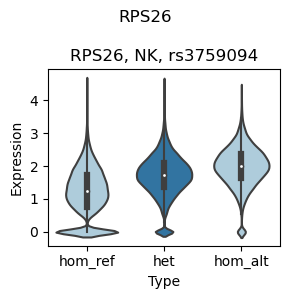

In [41]:
for gene in np.unique(eqtl.loc[selected_snps[0],  'Gene Ensembl ID']):
    plot_by_gene(gene, selected_snps[0])

### Select by correlation coefficient pvalues

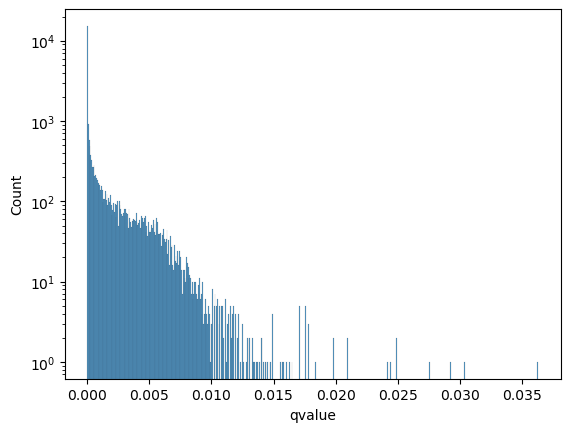

In [10]:
ax = sn.histplot(eqtl, x='qvalue')
ax.set_yscale('log')

In [9]:
eqtl_sorted = eqtl.sort_values('qvalue')
eqtl_sorted.head()

Unnamed: 0  Cell type Gene ID  Gene Ensembl ID         SNP  Chromosome  \
3657         3657     CD4 NC   RPS26  ENSG00000197728  rs10876864          12   
19248       19248         DC   RPS26  ENSG00000197728   rs1131017          12   
1926         1926      B Mem   RPS26  ENSG00000197728  rs10876864          12   
18195       18195  CD8 S100B   RPS26  ENSG00000197728  rs10876864          12   
12776       12776     CD8 NC   SMDT1  ENSG00000183172    rs133370          22   

       Position SNP assessed allele eSNP rank  rho correlation coefficient  \
3657   56401085                   A     eSNP1                       -0.892   
19248  56435929                   G     eSNP1                       -0.886   
1926   56401085                   A     eSNP1                       -0.890   
18195  56401085                   A     eSNP1                       -0.887   
12776  42465260                   C     eSNP1                        0.880   

       S-statistics  pvalue  qvalue       FDR  ref_samples  \
3657   2.985540e+08     0.0     0.0  0.000003            0   
19248  2.851213e+08     0.0     0.0  0.000023            0   
1926   2.983026e+08     0.0     0.0  0.000028            0   
18195  2.969301e+08     0.0     0.0  0.000044            0   
12776  1.886587e+07     0.0     0.0  0.000005            0   

                                         hom_ref_samples  \
3657   6_6,12_12,16_16,19_19,24_24,27_27,34_34,46_46,...   
19248  6_6,12_12,16_16,19_19,23_23,24_24,27_27,34_34,...   
1926   6_6,12_12,16_16,19_19,24_24,27_27,34_34,46_46,...   
18195  6_6,12_12,16_16,19_19,24_24,27_27,34_34,46_46,...   
12776  13_13,52_52,101_101,105_105,110_110,129_129,13...   

                                             het_samples  \
3657   1_1,2_2,3_3,7_7,9_9,10_10,13_13,14_14,15_15,18...   
19248  1_1,2_2,3_3,7_7,8_8,9_9,10_10,13_13,14_14,15_1...   
1926   1_1,2_2,3_3,7_7,9_9,10_10,13_13,14_14,15_15,18...   
18195  1_1,2_2,3_3,7_7,9_9,10_10,13_13,14_14,15_15,18...   
12776  1_1,4_4,6_6,8_8,14_14,15_15,16_16,19_19,21_21,...   

                                         hom_alt_samples  
3657   4_4,8_8,11_11,17_17,26_26,30_30,33_33,35_35,39...  
19248  4_4,11_11,17_17,26_26,30_30,33_33,35_35,39_39,...  
1926   4_4,8_8,11_11,17_17,26_26,30_30,33_33,35_35,39...  
18195  4_4,8_8,11_11,17_17,26_26,30_30,33_33,35_35,39...  
12776  2_2,3_3,7_7,9_9,10_10,11_11,12_12,17_17,18_18,...

In [12]:
30/eqtl.shape[0]

0.001127946760912885

Take the first 30 -> ca top 0.1%

In [13]:
np.unique(eqtl_sorted.iloc[:30, :]['Gene ID'])

array(['CENPK', 'EIF5A', 'ERAP2', 'FAM184B', 'PSMD5-AS1', 'RPL8', 'RPS26',
       'SH3YL1', 'SMDT1', 'SNHG8', 'TOMM7', 'XRRA1'], dtype=object)

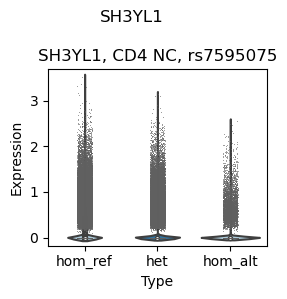

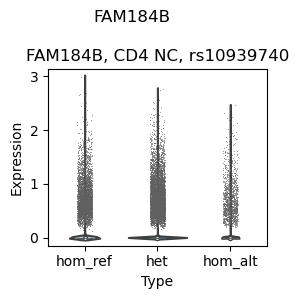

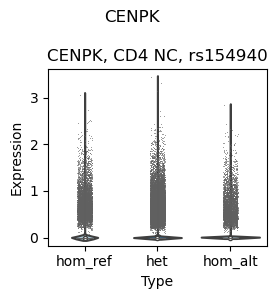

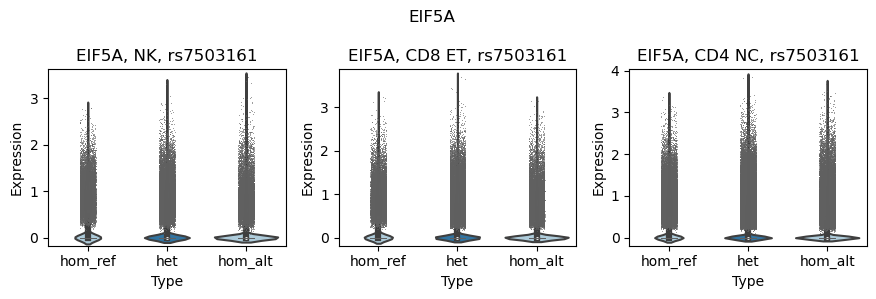

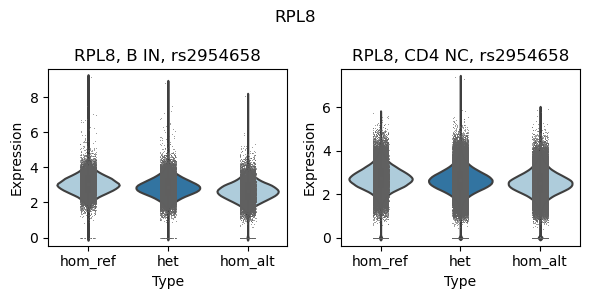

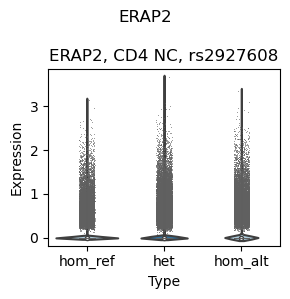

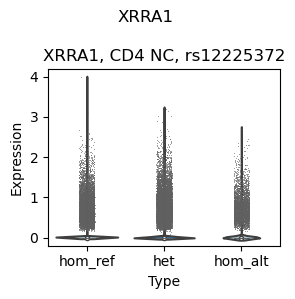

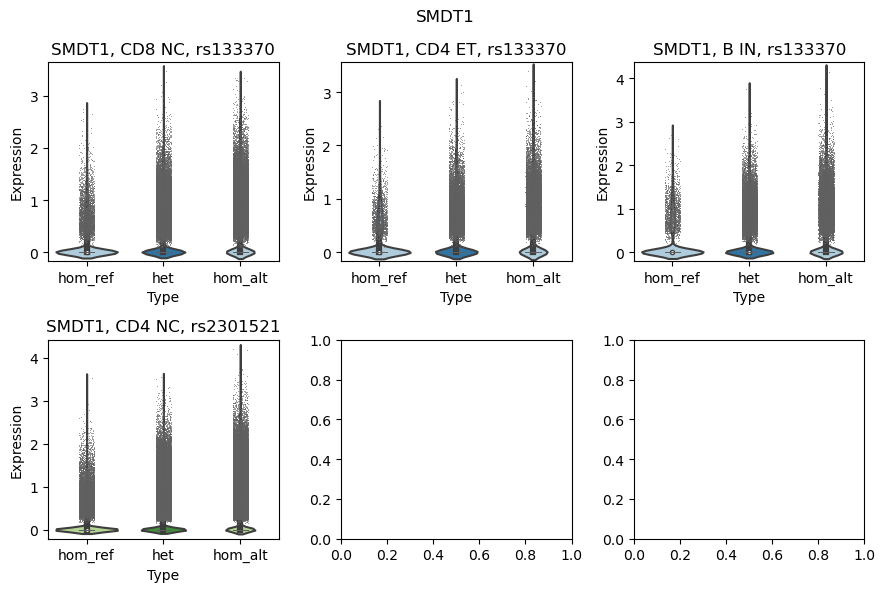

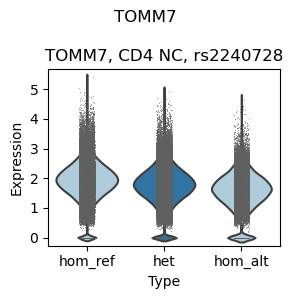

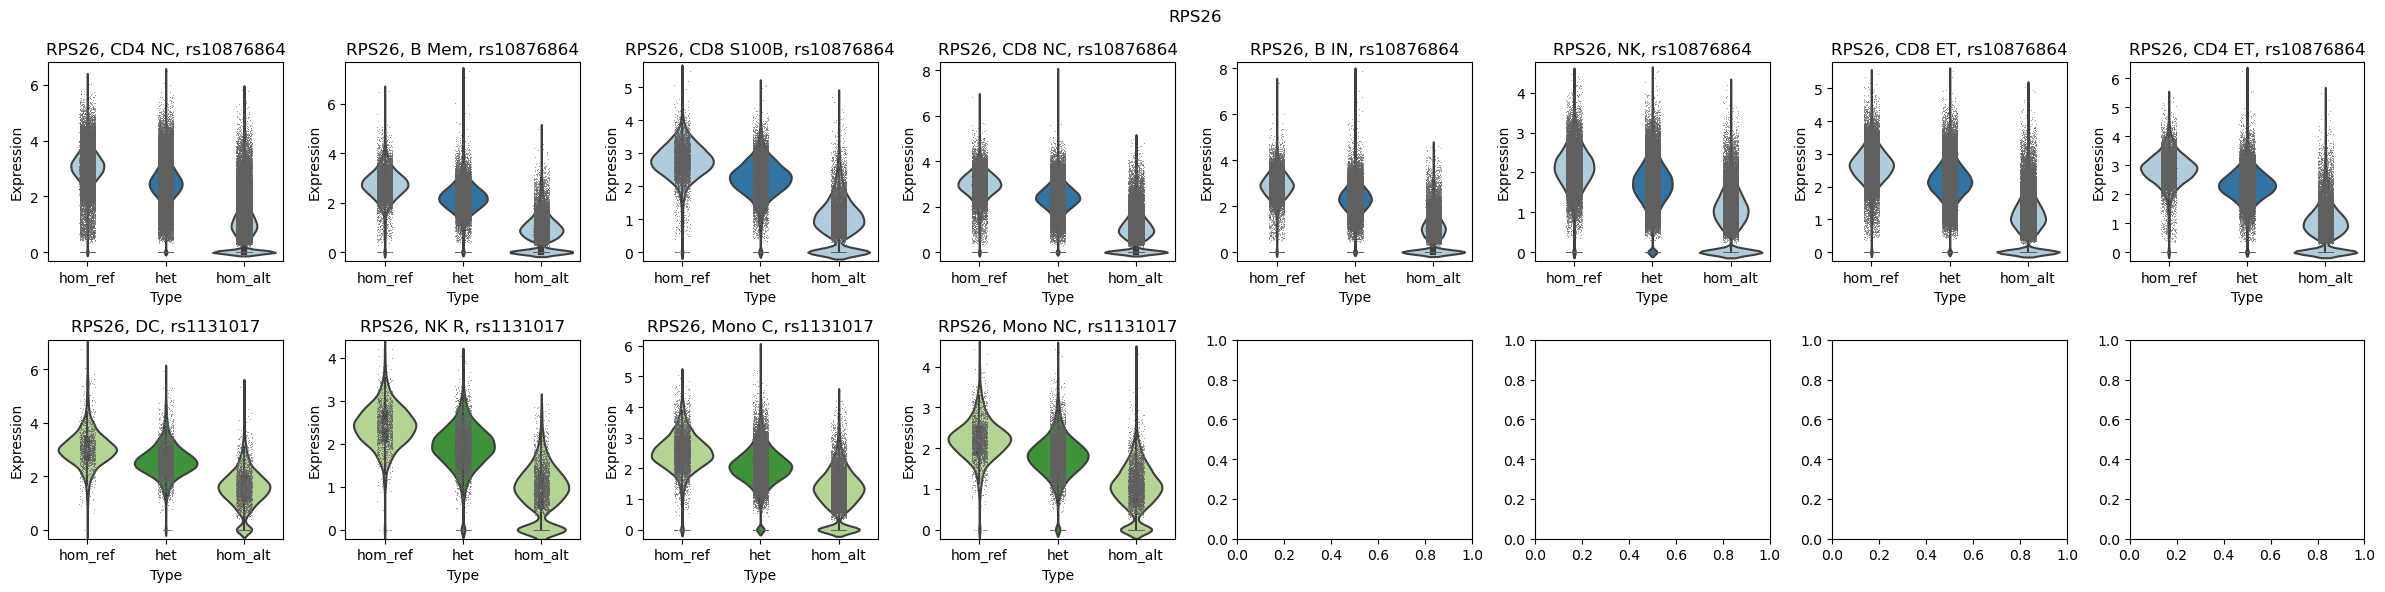

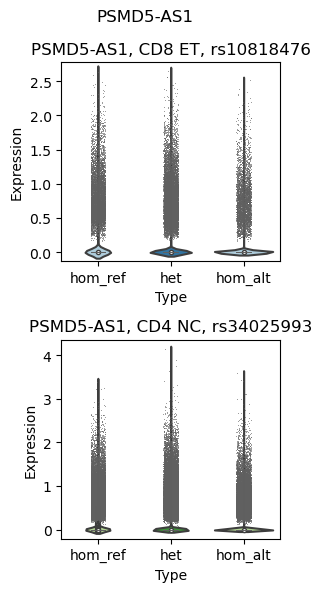

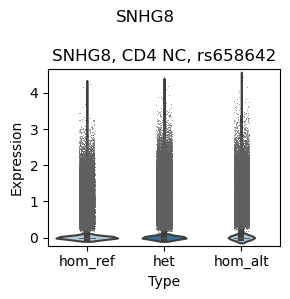

In [10]:
for gene in np.unique(eqtl_sorted.iloc[:30, :]['Gene Ensembl ID']):
    plot_by_gene(gene, eqtl_sorted.index.values[:30], savefig=f'figures/{gene}_sortby_qvalue.png')

# Transcription factors

In [11]:
tf_df = pd.read_csv('/home/e860a/chernova/my_onek1k_data/TF_list.csv')

In [12]:
tf_df = tf_df[tf_df['Is TF?']=='Yes']

In [13]:
# TFs which expression was tested
np.intersect1d(data.var.index, tf_df['Ensembl ID']).shape

(1606,)

In [14]:
# TFs where an SNP was found
tf_ids = np.intersect1d(eqtl['Gene Ensembl ID'], tf_df['Ensembl ID'])
tf_ids.shape

(386,)

In [16]:
# Only select eQTLs acting on TFs
search_str = '|'.join(tf_ids)
tf_eqtl = eqtl[eqtl['Gene Ensembl ID'].str.contains(search_str, regex=True)]

In [17]:
tf_eqtl_sort = tf_eqtl.sort_values('qvalue')
tf_eqtl_sort.head()

Unnamed: 0  Cell type Gene ID  Gene Ensembl ID         SNP  Chromosome  \
7249         7249     CD4 NC  HMBOX1  ENSG00000147421  rs10088428           8   
4437         4437     CD4 NC   HOXB2  ENSG00000173917  rs12450225          17   
19192       19192  CD8 S100B   ZFP57  ENSG00000204644   rs1362070           6   
19100       19100  CD8 S100B   ZFP57  ENSG00000204644   rs1362068           6   
18999       18999  CD8 S100B   ZFP57  ENSG00000204644   rs1610634           6   

       Position SNP assessed allele eSNP rank  rho correlation coefficient  \
7249   28909523                   T     eSNP1                       -0.706   
4437   46592413                   G     eSNP1                        0.595   
19192  29742299                   C     eSNP5                       -0.551   
19100  29742108                   C     eSNP4                       -0.551   
18999  29738454                   C     eSNP3                       -0.551   

       S-statistics         pvalue         qvalue           FDR  ref_samples  \
7249   2.691842e+08  9.570000e-149  2.860000e-144  2.260000e-06            0   
4437   6.384815e+07   2.870000e-95   3.900000e-92  1.650000e-06            0   
19192  2.440984e+08   4.220000e-79   2.950000e-76  3.950000e-08            0   
19100  2.440984e+08   4.220000e-79   3.430000e-76  6.900000e-08            0   
18999  2.440984e+08   4.220000e-79   3.840000e-76  7.480000e-08            0   

                                         hom_ref_samples  \
7249   3_3,4_4,7_7,10_10,11_11,13_13,14_14,16_16,17_1...   
4437   2_2,11_11,13_13,15_15,16_16,19_19,24_24,32_32,...   
19192  3_3,4_4,12_12,13_13,14_14,18_18,24_24,25_25,27...   
19100  3_3,4_4,12_12,13_13,14_14,18_18,24_24,25_25,27...   
18999  3_3,4_4,12_12,13_13,14_14,18_18,24_24,25_25,27...   

                                             het_samples  \
7249   1_1,2_2,6_6,8_8,12_12,15_15,20_20,24_24,35_35,...   
4437   1_1,3_3,4_4,8_8,9_9,14_14,17_17,18_18,20_20,23...   
19192  1_1,2_2,6_6,7_7,8_8,9_9,10_10,16_16,17_17,19_1...   
19100  1_1,2_2,6_6,7_7,8_8,9_9,10_10,16_16,17_17,19_1...   
18999  1_1,2_2,6_6,7_7,8_8,9_9,10_10,16_16,17_17,19_1...   

                                         hom_alt_samples  
7249   9_9,19_19,33_33,48_48,58_58,67_67,68_68,75_75,...  
4437   6_6,7_7,10_10,12_12,21_21,25_25,26_26,28_28,29...  
19192  11_11,15_15,23_23,46_46,47_47,48_48,51_51,59_5...  
19100  11_11,15_15,23_23,46_46,47_47,48_48,51_51,59_5...  
18999  11_11,15_15,23_23,46_46,47_47,48_48,51_51,59_5...

In [18]:
tf_eqtl.shape

(1326, 18)

Plotting eQTLs with 20 top q-values:

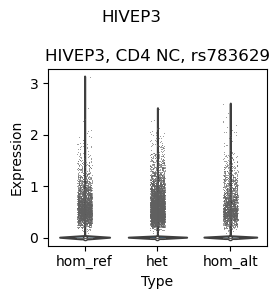

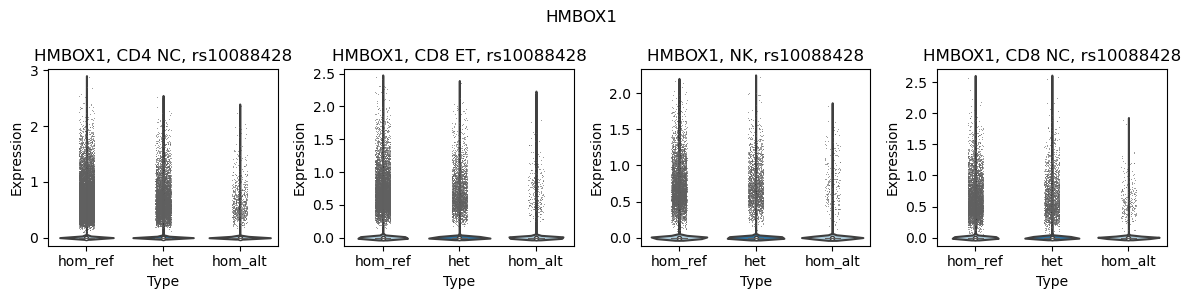

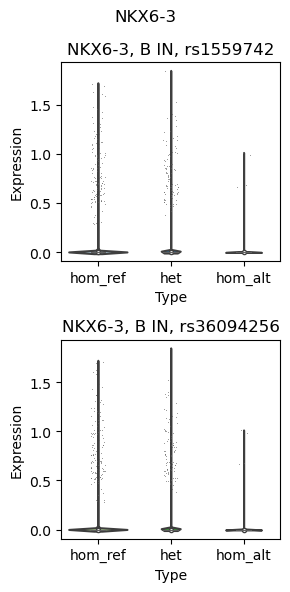

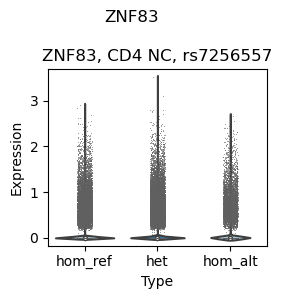

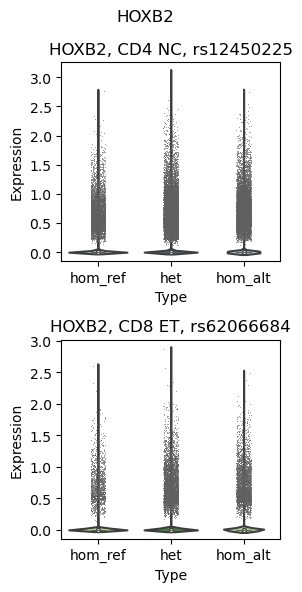

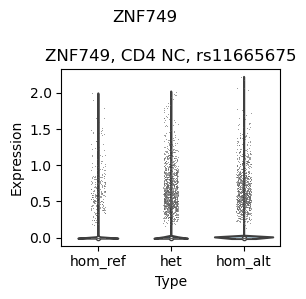

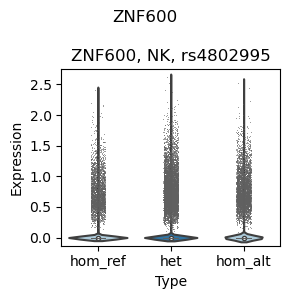

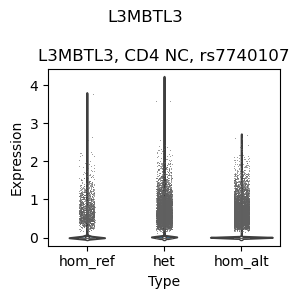

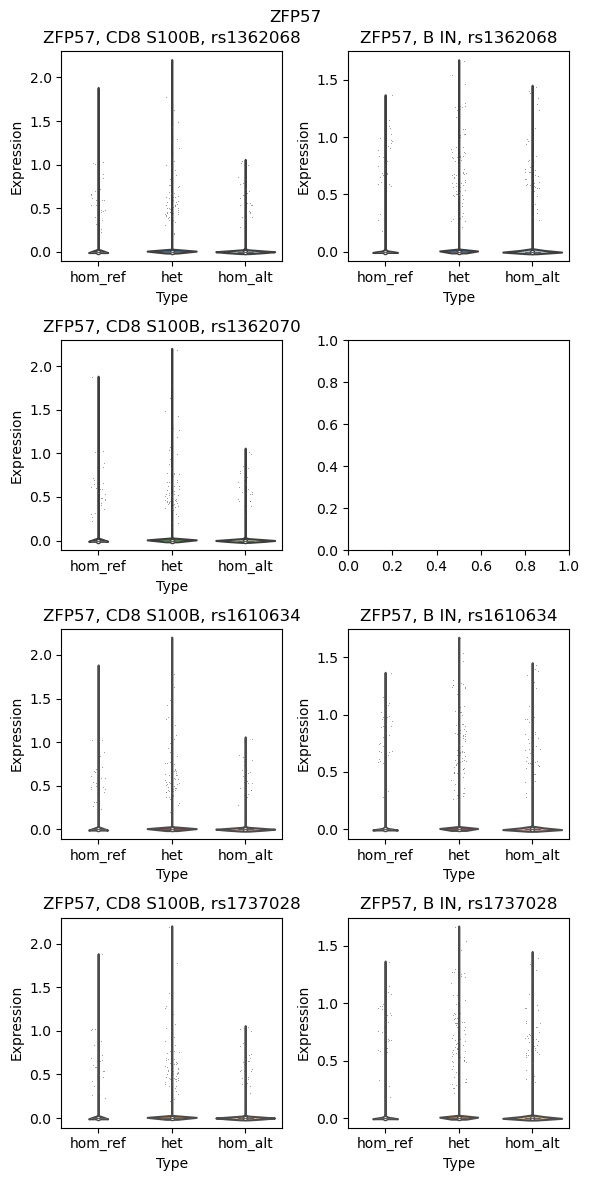

In [22]:
n = 20
for gene in np.unique(tf_eqtl_sort.iloc[:n, :]['Gene Ensembl ID']):
    plot_by_gene(gene, tf_eqtl_sort.index.values[:n], savefig=f'figures/tf_{gene}_sortby_qvalue.png')

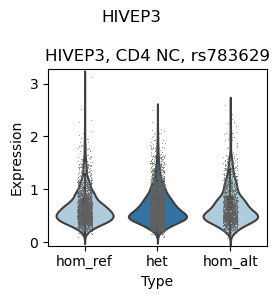

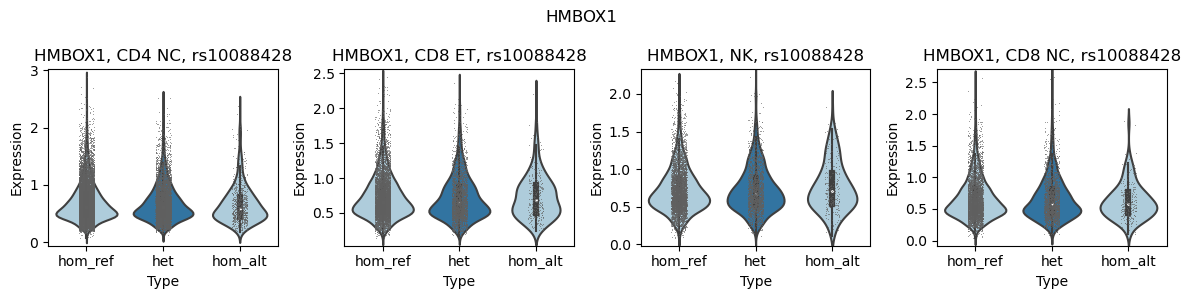

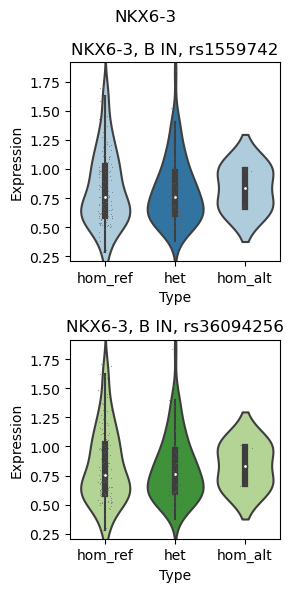

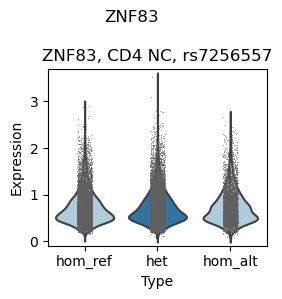

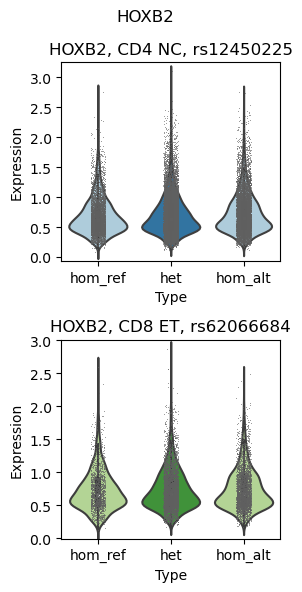

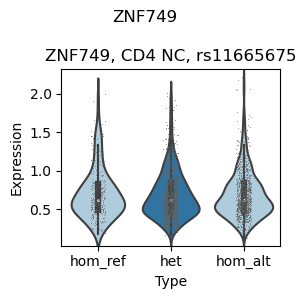

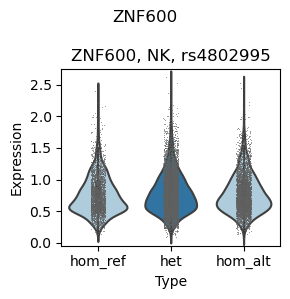

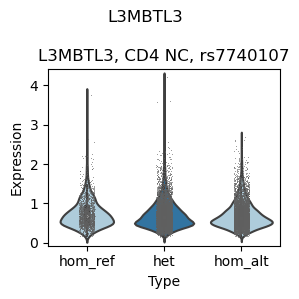

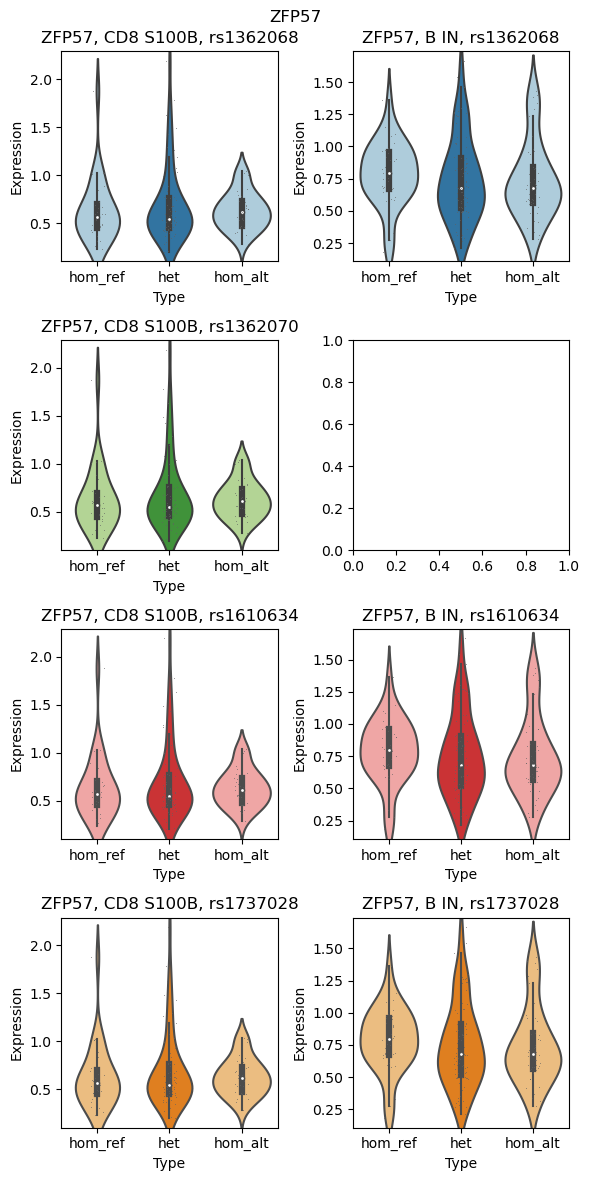

In [21]:
n = 20
for gene in np.unique(tf_eqtl_sort.iloc[:n, :]['Gene Ensembl ID']):
    plot_by_gene(gene, tf_eqtl_sort.index.values[:n], delete_zeros=True, savefig=f'figures/tf_{gene}_dekete0_sortby_qvalue.png')

In [ ]:
n = 20
delete_zeros = True
for gene in np.unique(tf_eqtl_sort.iloc[:n, :]['Gene Ensembl ID']):
    plot_by_gene(gene, tf_eqtl_sort.index.values[:n], delete_zeros=delete_zeros)

## Calculate t-values without zero values 
### Only eQTLs acting on TFs

Run as a submitted job

In [298]:
# df = tf_eqtl
# t_vals = np.zeros((3, df.shape[0])) # (t statistic, p value, degrees of freedom), number of SNPs
# colnames = ['hom_ref_samples', 'het_samples', 'hom_alt_samples']
# for i, snp in tqdm(enumerate(df.index.values[:10])):
#     ok = True
#     expr_list = []
#     for col in [0, 2]:
#         search_str = df.loc[snp, colnames[col]] # Select the string with the right patients
#         if type(search_str)==str:
#             search_str = search_str.replace(',', '|') # Transform to regex

#             gene = df.loc[snp, 'Gene Ensembl ID']
#             cell_type = df.loc[snp, 'Cell type']

#             mask = np.logical_and(data.obs.individual.str.contains(search_str, regex=True),
#                                   data.obs['old_cell_label']==cell_type)

#             x = data[mask, gene].X.copy().todense()
#             if np.sum(x==0)<x.shape[0]:
#                 x = x[x!=0]
#             else:
#                 ok=False
#             expr_list.append(x)

#         else:
#             ok = False
#             #print(f'Not a string at row {snp}, column {col}')
        
        
#     if ok:
#         test = stats.ttest_ind(expr_list[0], expr_list[1], axis=1)
#         t_vals[0, i] = test.statistic
#         t_vals[1, i] = test.pvalue
#         t_vals[2, i] = expr_list[0].shape[1]+expr_list[1].shape[1]
#     else:
#         t_vals[0, i] = np.nan
#         t_vals[1, i] = np.nan
#         t_vals[2, i] = np.nan

In [344]:
t_vals = np.load('/home/e860a/chernova/my_onek1k_data/tvals_homref_homalt_tf_nozero.npz')
t_vals.files

['tvals', 'pvalue', 'df']

In [345]:
tvals = t_vals['tvals']
pvals = t_vals['pvalue']
dfs = t_vals['df']

<Axes: >

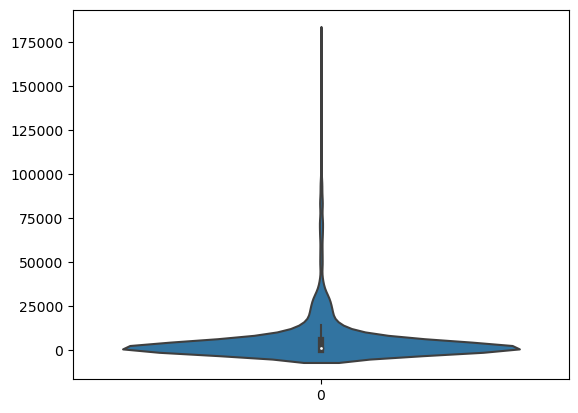

In [346]:
sn.violinplot(dfs)

Text(0.5, 0, 't statistic')

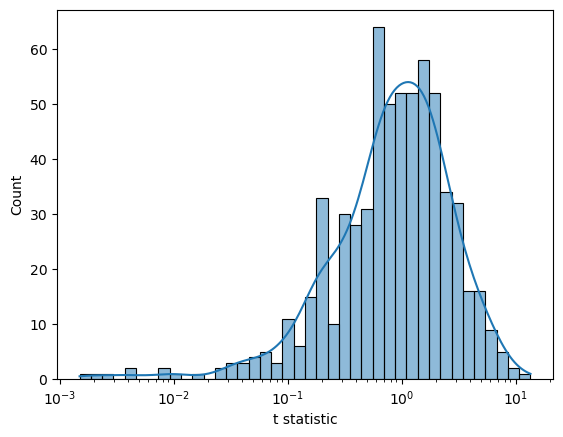

In [347]:
sn.histplot(tvals, bins=40, kde=True, log_scale=10)
plt.xlabel('t statistic')

Text(0.5, 0, 'p values')

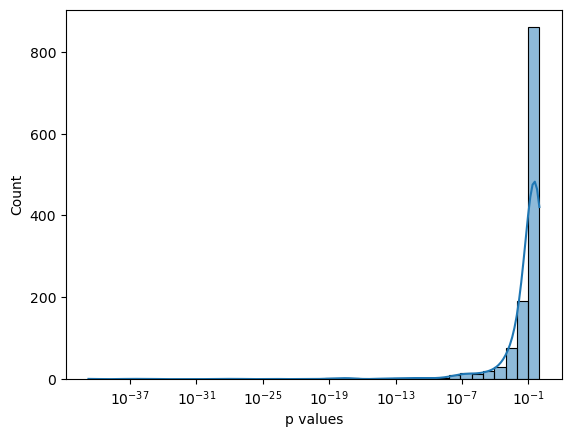

In [359]:
sn.histplot(pvals, bins=40, kde=True, log_scale=10)
plt.xlabel('p values')

#### Select by p-value

In [361]:
selected_snps = tf_eqtl.index.values[np.where(np.abs(pvals)<=10e-10)[0]]
selected_snps.shape

(25,)

Summarize eQTLs with top p-values by gene name and cell type.

In [362]:
names = {}
tot_count = {}
for i in selected_snps:
    snp = i
    gene_name = tf_eqtl.loc[snp, 'Gene ID']
    cell = tf_eqtl.loc[snp, 'Cell type']
    if f'{gene_name}_{cell}' in names.keys():
        names[f'{gene_name}_{cell}'] += 1
    else:
        names[f'{gene_name}_{cell}'] = 1
    
    if gene_name in tot_count.keys():
        tot_count[gene_name] += 1
    else:
        tot_count[gene_name] = 1
        
g_names = []
c_names = []
counts = []
t_counts = []
for k in names.keys():
    g_names.append(k.split('_')[0])
    c_names.append(k.split('_')[1])
    counts.append(names[k])
    t_counts.append(tot_count[k.split('_')[0]])
df = pd.DataFrame({'Gene': g_names, 'Cell': c_names, 'Count': counts, 'Total_count': t_counts})
df.sort_values(['Total_count', 'Gene'], ascending=False)

Gene    Cell  Count  Total_count
10    XBP1  CD4 NC      2            3
15    XBP1  CD8 ET      1            3
3     ETS1  CD4 NC      1            3
13    ETS1  CD8 NC      1            3
21    ETS1      NK      1            3
0    SP110    B IN      1            2
16   SP110  CD8 ET      1            2
12   IKZF1  CD4 NC      2            2
5    GTF3A  CD4 NC      1            2
18   GTF3A      NK      1            2
11    ATF4  CD4 NC      1            2
17    ATF4  CD8 ET      1            2
1   ARID5B  CD4 NC      2            2
6   ZBTB25  CD4 NC      1            1
14   ZBTB1  CD8 ET      1            1
8     THRA  CD4 NC      1            1
20    MAFF      NK      1            1
2     KLF6  CD4 NC      1            1
7    HOXB2  CD4 NC      1            1
19    ELF1      NK      1            1
4     EEA1  CD4 NC      1            1
9   CAMTA1  CD4 NC      1            1

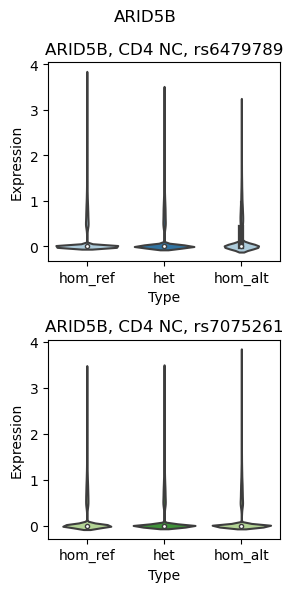

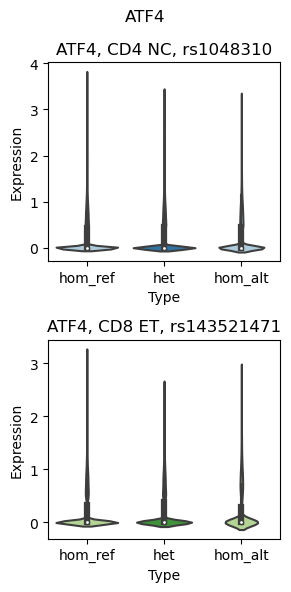

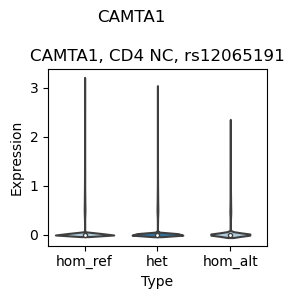

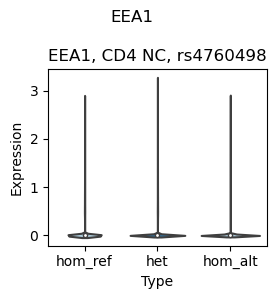

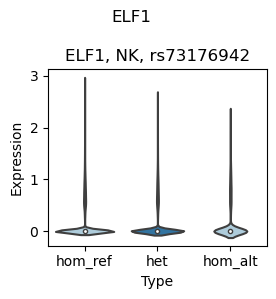

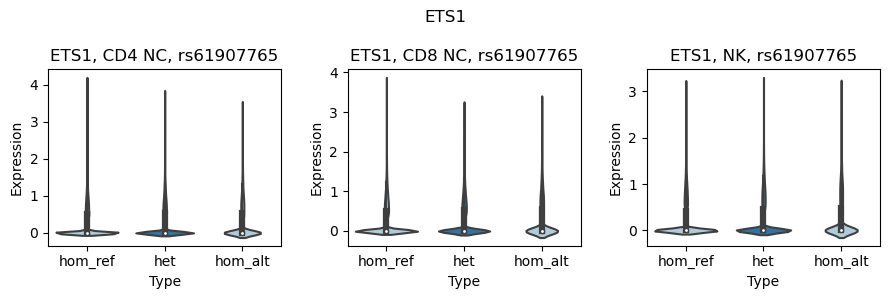

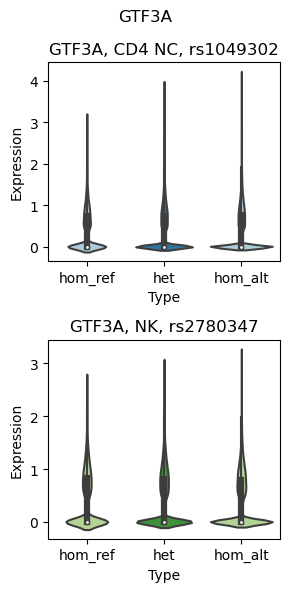

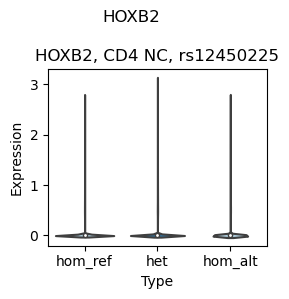

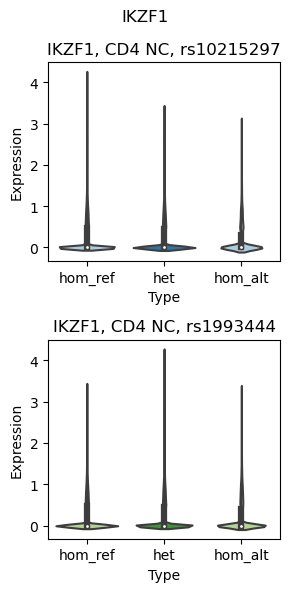

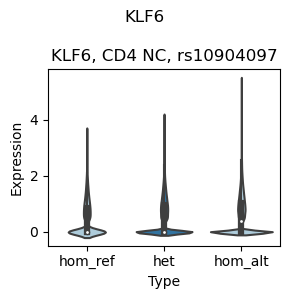

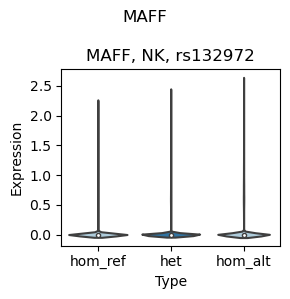

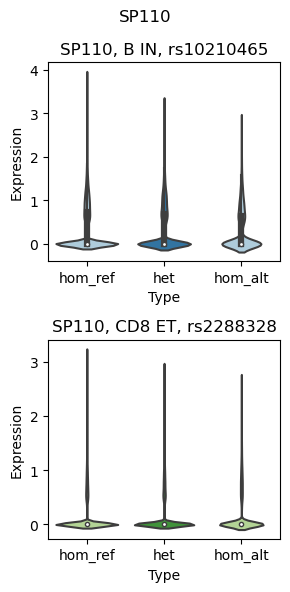

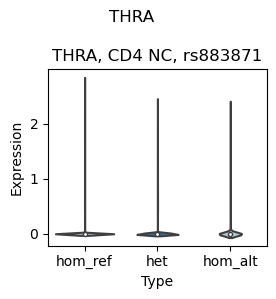

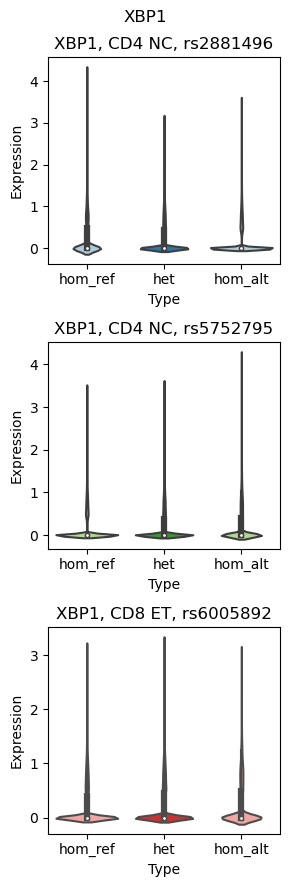

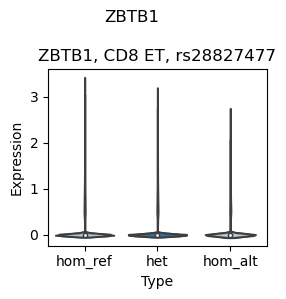

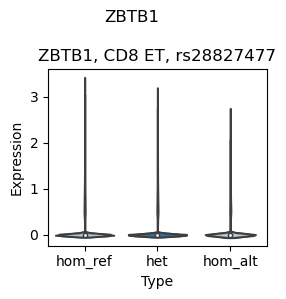

In [364]:
for gene in np.unique(tf_eqtl.loc[selected_snps, :]['Gene Ensembl ID']):
    plot_by_gene(gene, selected_snps)

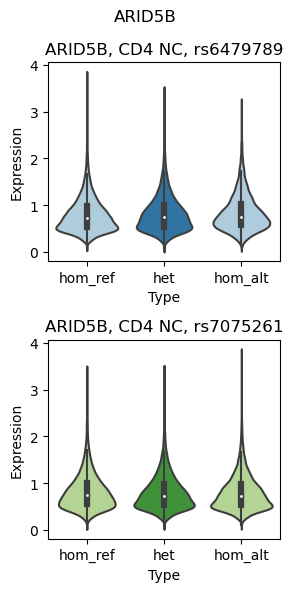

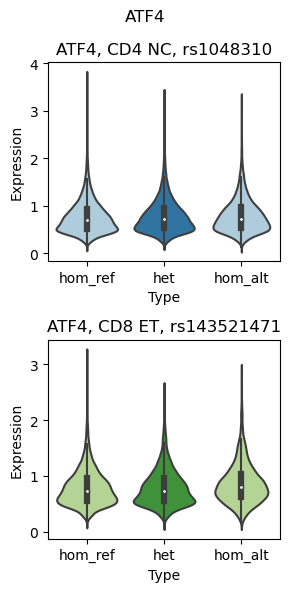

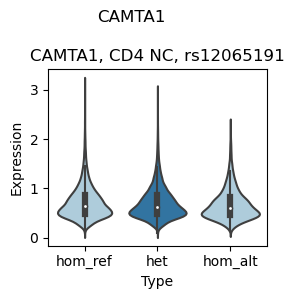

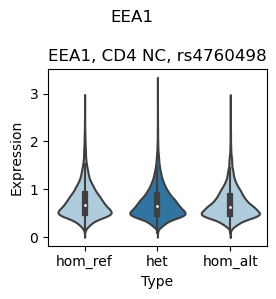

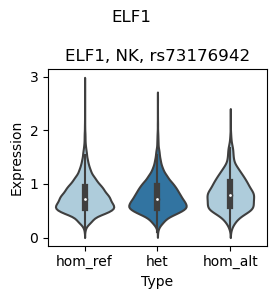

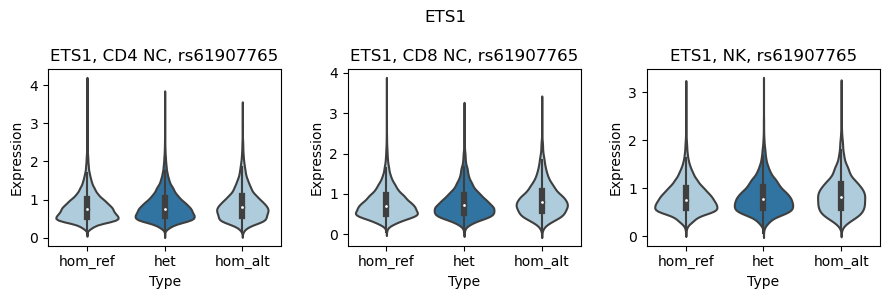

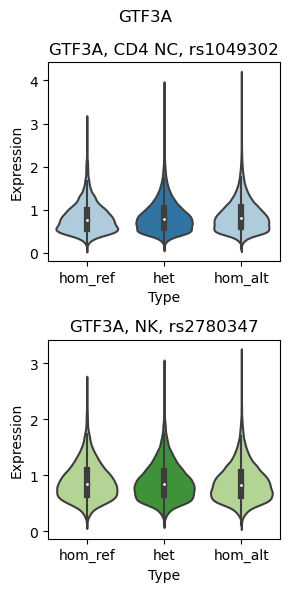

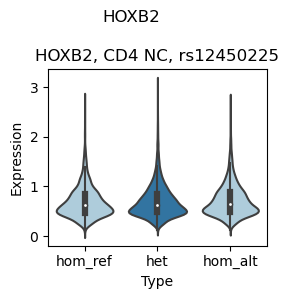

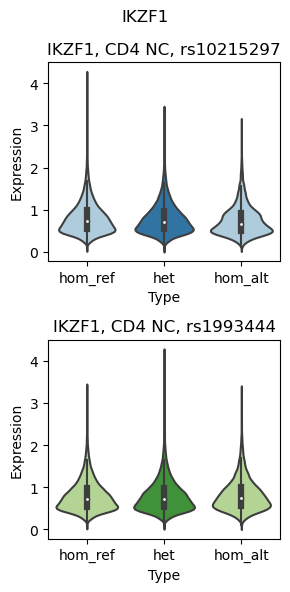

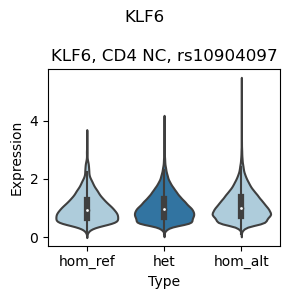

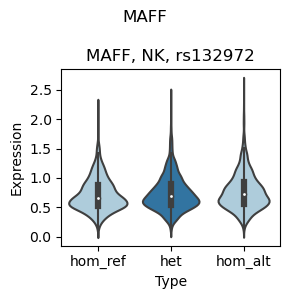

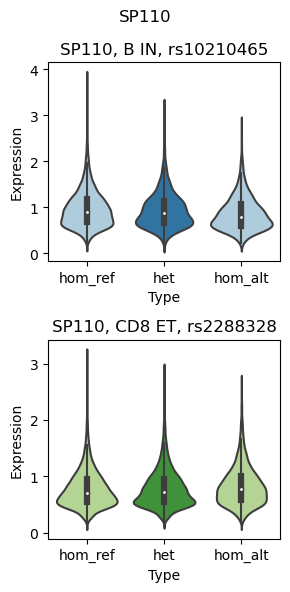

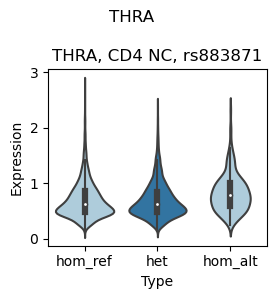

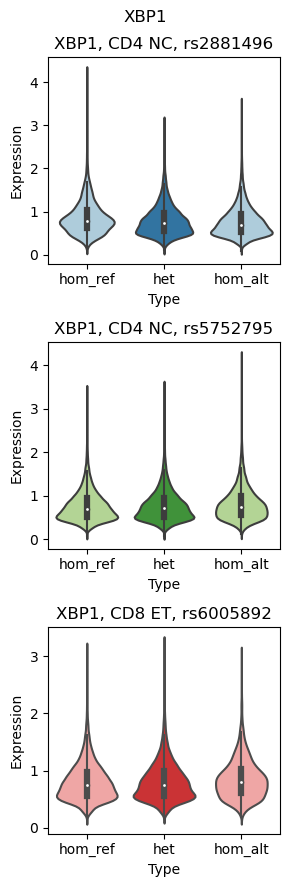

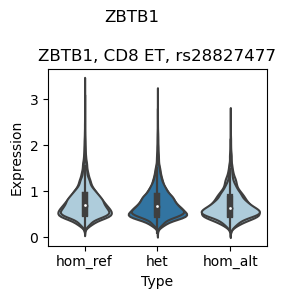

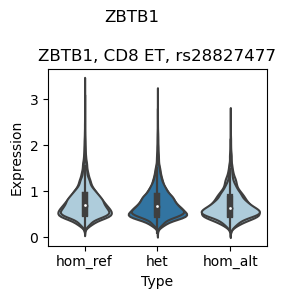

In [376]:
for gene in np.unique(tf_eqtl.loc[selected_snps, :]['Gene Ensembl ID']):
    plot_by_gene(gene, selected_snps, delete_zeros=True)

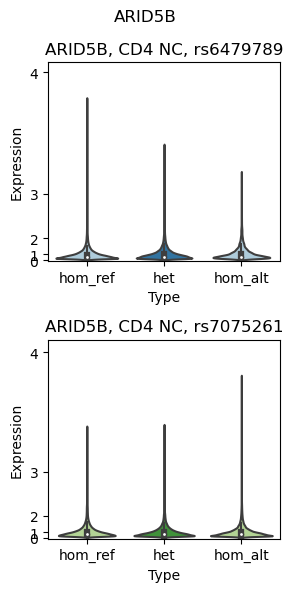

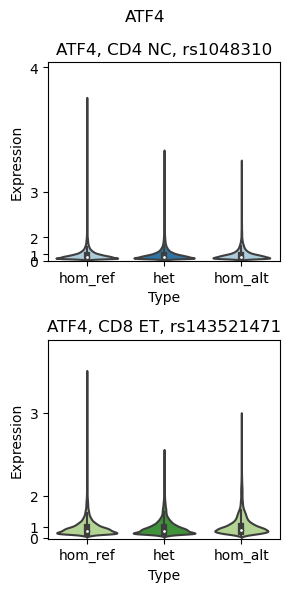

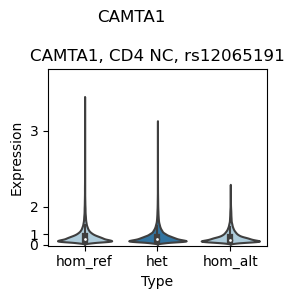

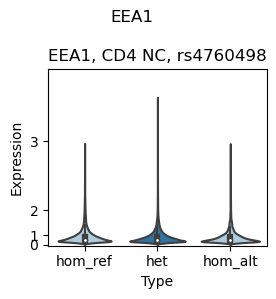

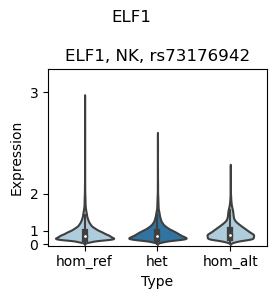

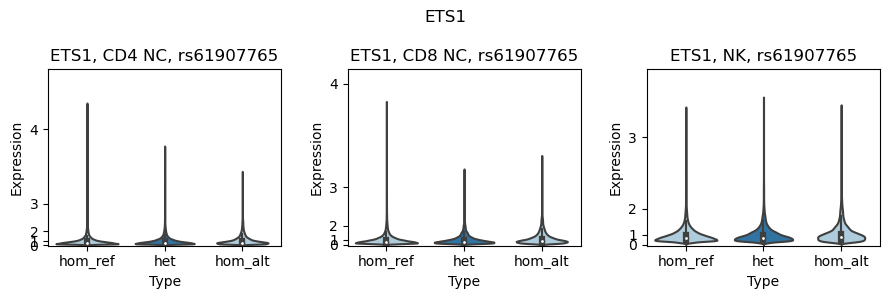

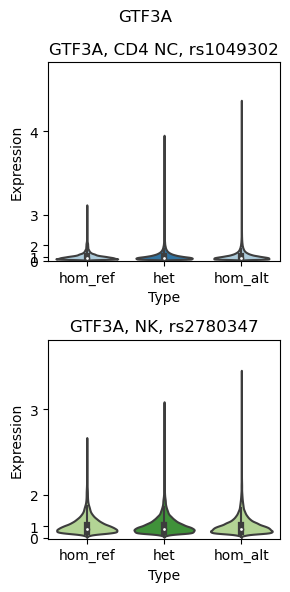

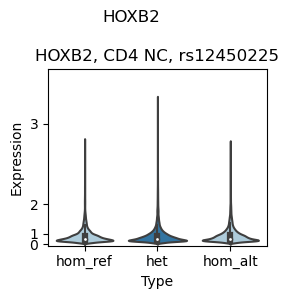

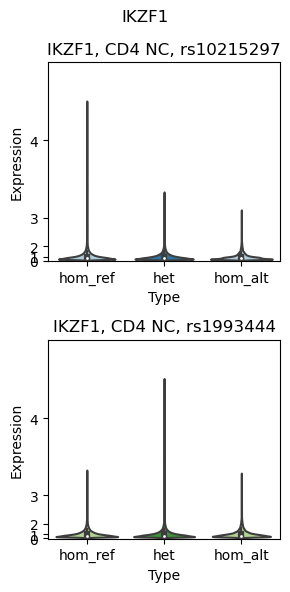

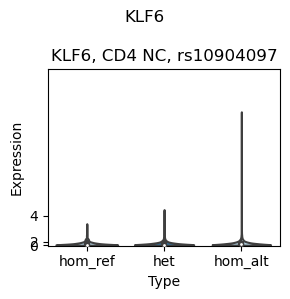

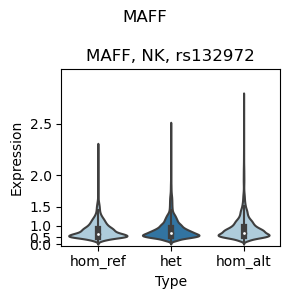

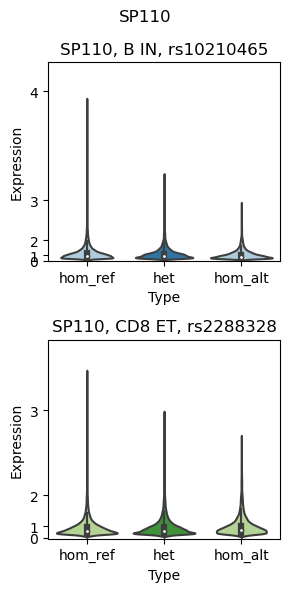

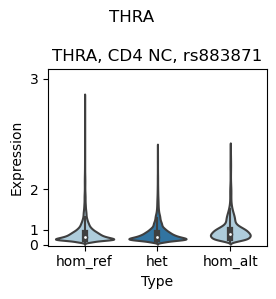

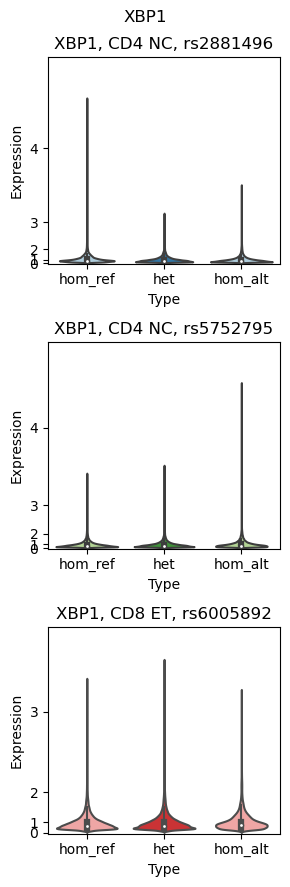

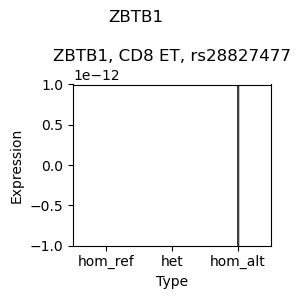

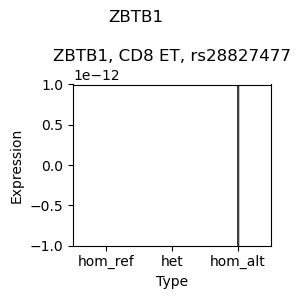

In [375]:
for gene in np.unique(tf_eqtl.loc[selected_snps, :]['Gene Ensembl ID']):
    plot_by_gene(gene, selected_snps, delete_zeros=True, exponential=True)

#### Select by t-statistic

Text(0.5, 0, 't statistic')

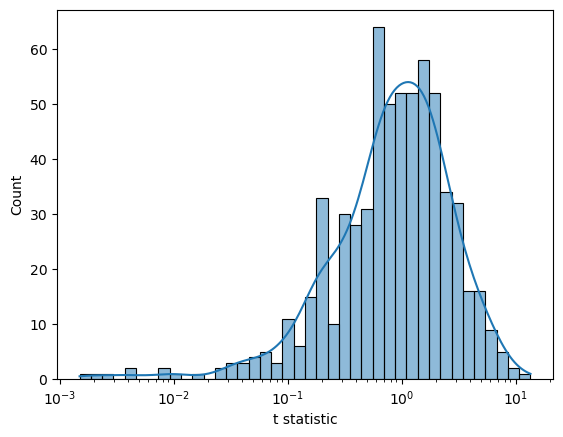

In [347]:
sn.histplot(tvals, bins=40, kde=True, log_scale=10)
plt.xlabel('t statistic')

In [379]:
selected_snps = tf_eqtl.index.values[np.where(np.abs(tvals)>=6)[0]]
selected_snps.shape

(25,)

Summarize eQTLs with top t-statistics values by gene name and cell type.

In [380]:
names = {}
tot_count = {}
for i in selected_snps:
    snp = i
    gene_name = tf_eqtl.loc[snp, 'Gene ID']
    cell = tf_eqtl.loc[snp, 'Cell type']
    if f'{gene_name}_{cell}' in names.keys():
        names[f'{gene_name}_{cell}'] += 1
    else:
        names[f'{gene_name}_{cell}'] = 1
    
    if gene_name in tot_count.keys():
        tot_count[gene_name] += 1
    else:
        tot_count[gene_name] = 1
        
g_names = []
c_names = []
counts = []
t_counts = []
for k in names.keys():
    g_names.append(k.split('_')[0])
    c_names.append(k.split('_')[1])
    counts.append(names[k])
    t_counts.append(tot_count[k.split('_')[0]])
df = pd.DataFrame({'Gene': g_names, 'Cell': c_names, 'Count': counts, 'Total_count': t_counts})
df.sort_values(['Total_count', 'Gene'], ascending=False)

Gene    Cell  Count  Total_count
10    XBP1  CD4 NC      2            3
15    XBP1  CD8 ET      1            3
3     ETS1  CD4 NC      1            3
13    ETS1  CD8 NC      1            3
21    ETS1      NK      1            3
0    SP110    B IN      1            2
16   SP110  CD8 ET      1            2
12   IKZF1  CD4 NC      2            2
5    GTF3A  CD4 NC      1            2
18   GTF3A      NK      1            2
11    ATF4  CD4 NC      1            2
17    ATF4  CD8 ET      1            2
1   ARID5B  CD4 NC      2            2
6   ZBTB25  CD4 NC      1            1
14   ZBTB1  CD8 ET      1            1
8     THRA  CD4 NC      1            1
20    MAFF      NK      1            1
2     KLF6  CD4 NC      1            1
7    HOXB2  CD4 NC      1            1
19    ELF1      NK      1            1
4     EEA1  CD4 NC      1            1
9   CAMTA1  CD4 NC      1            1

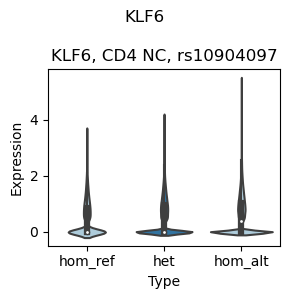

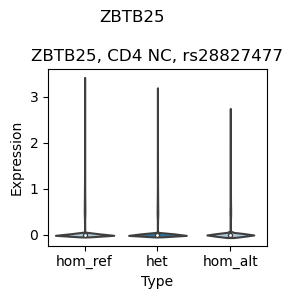

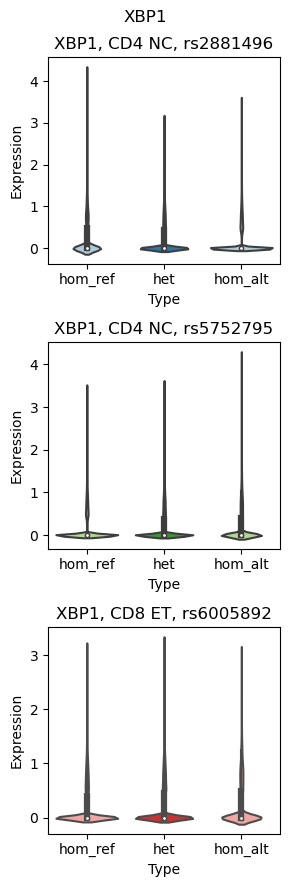

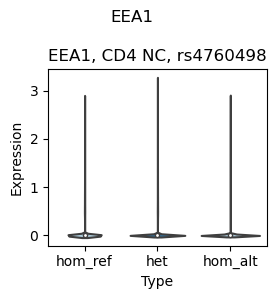

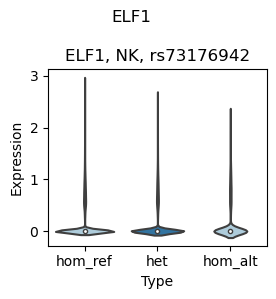

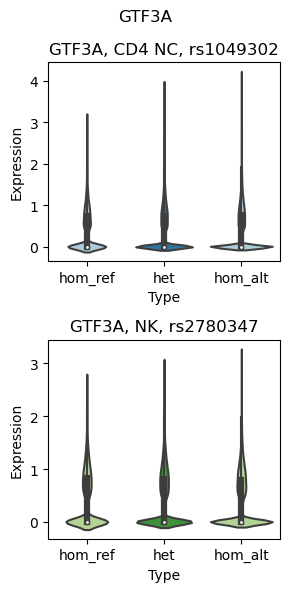

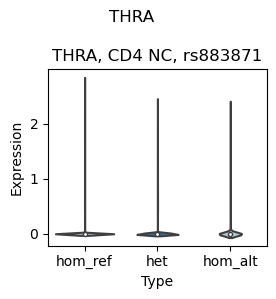

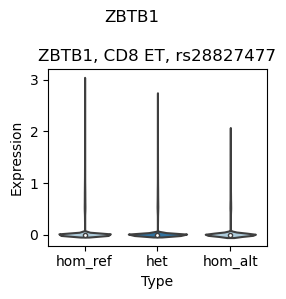

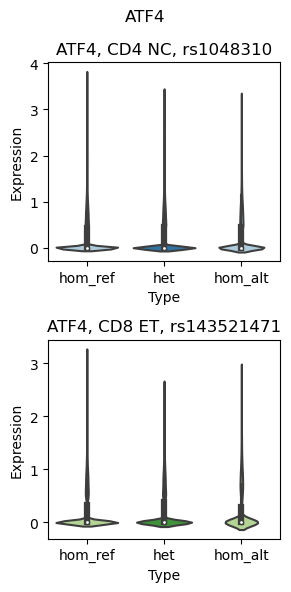

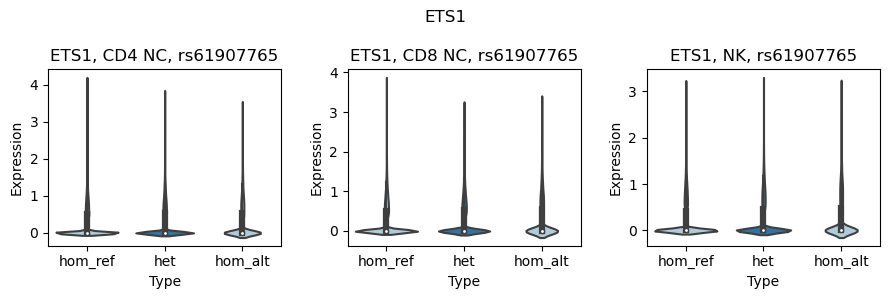

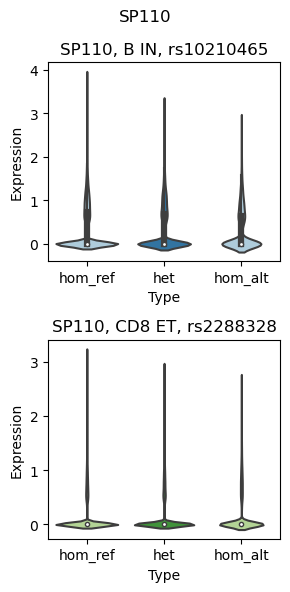

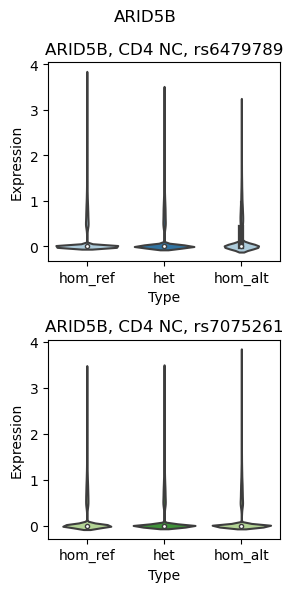

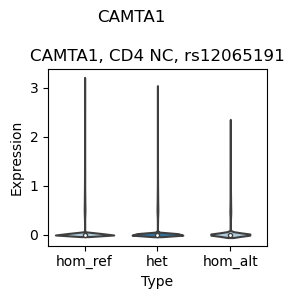

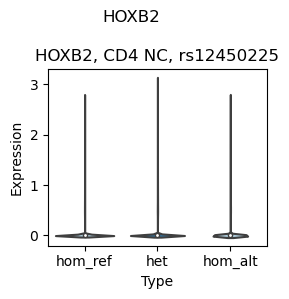

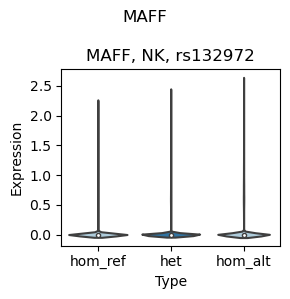

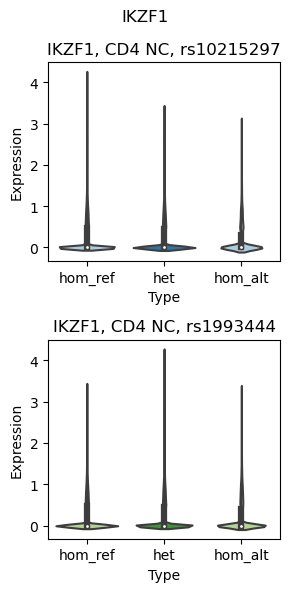

In [419]:
for gene in np.unique(tf_eqtl.loc[selected_snps, :]['Gene Ensembl ID']):
    plot_by_gene(gene, selected_snps)

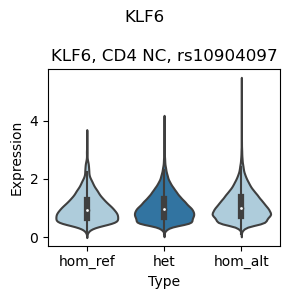

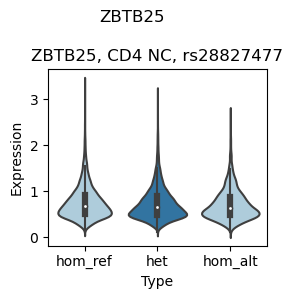

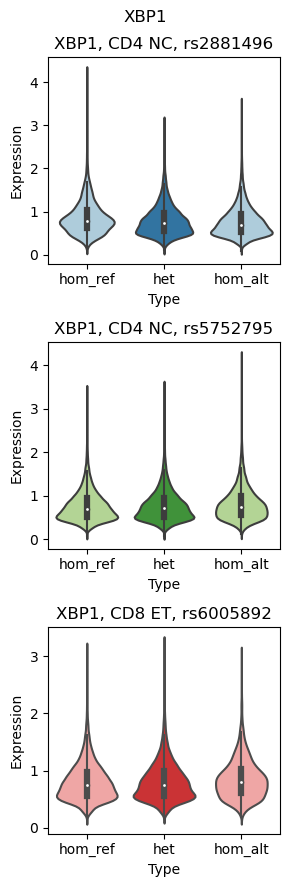

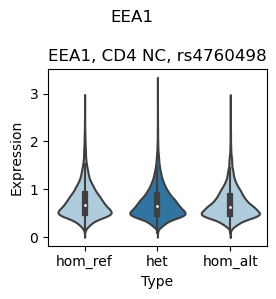

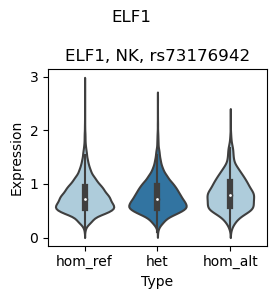

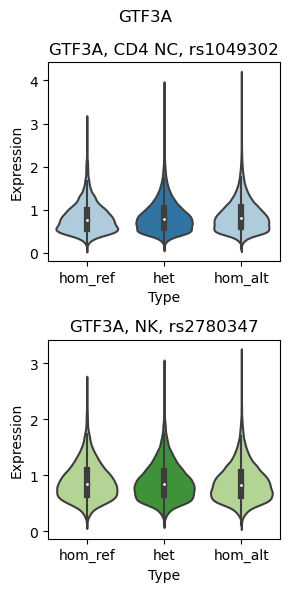

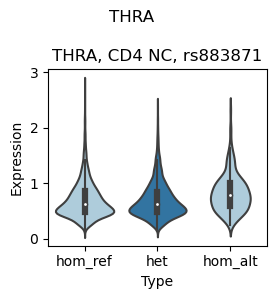

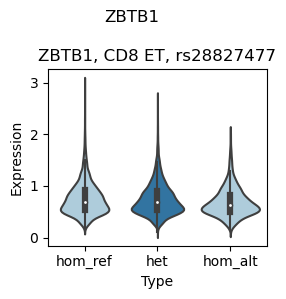

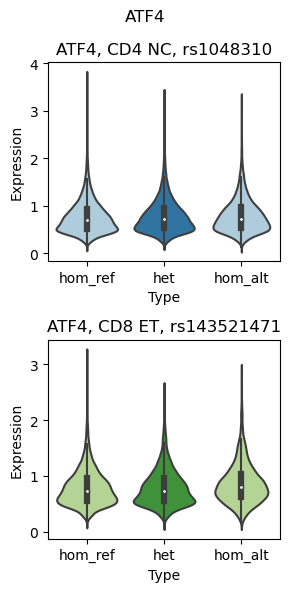

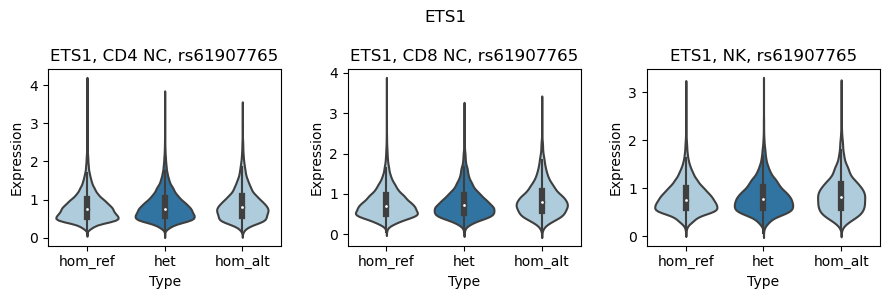

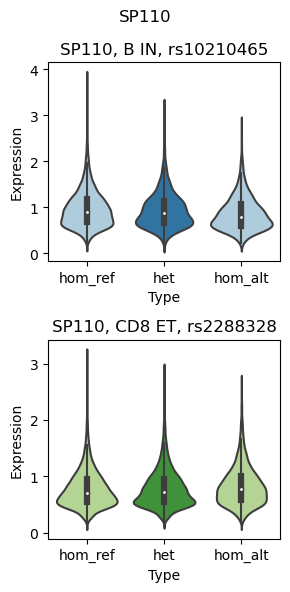

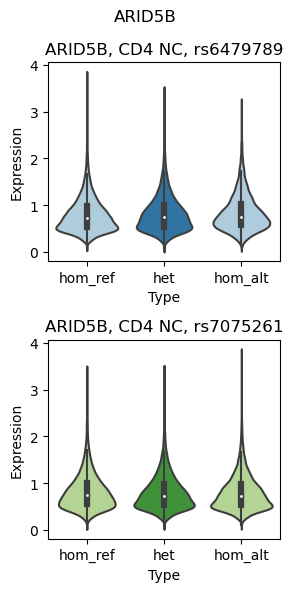

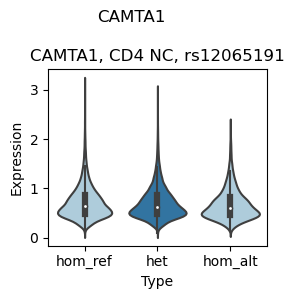

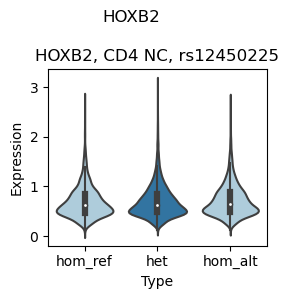

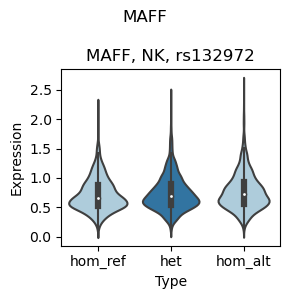

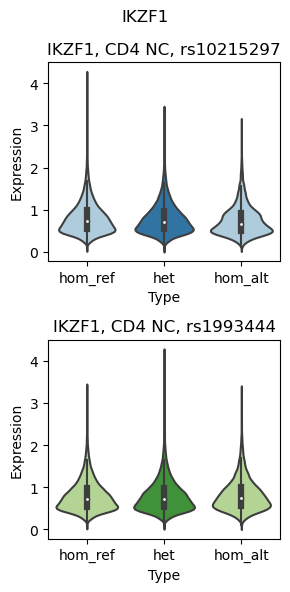

In [420]:
for gene in np.unique(tf_eqtl.loc[selected_snps, :]['Gene Ensembl ID']):
    plot_by_gene(gene, selected_snps, delete_zeros=True)

# T-test results without taking zero values into the account

For all eQTLs (not only the ones acting on TFs)

In [ ]:
t_vals = np.load('/home/e860a/chernova/my_onek1k_data/tvals_homref_homalt_nozero.npz')
t_vals.files

In [422]:
tvals = t_vals['tvals']
pvals = t_vals['pvalue']
dfs = t_vals['df']

<Axes: >

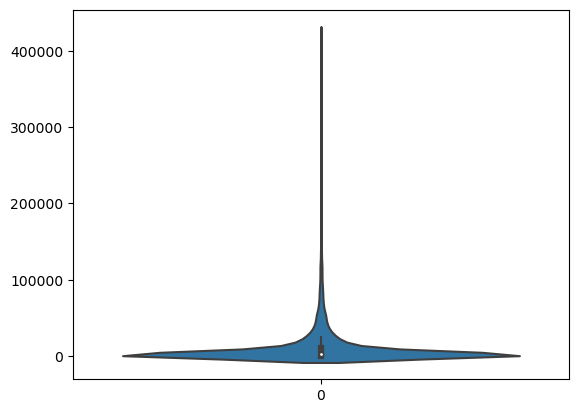

In [423]:
sn.violinplot(dfs)

Text(0.5, 0, 't statistic')

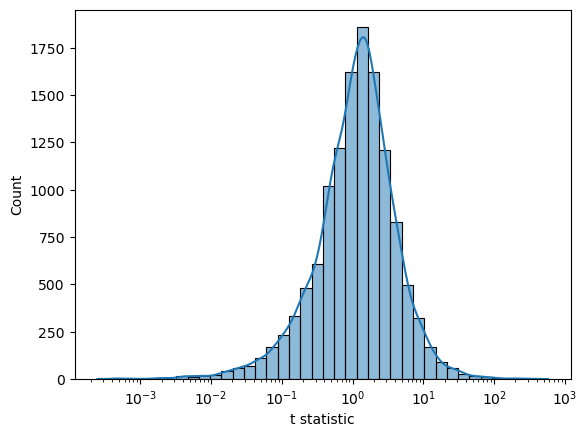

In [424]:
sn.histplot(tvals, bins=40, kde=True, log_scale=10)
plt.xlabel('t statistic')

Text(0.5, 0, 'p values')

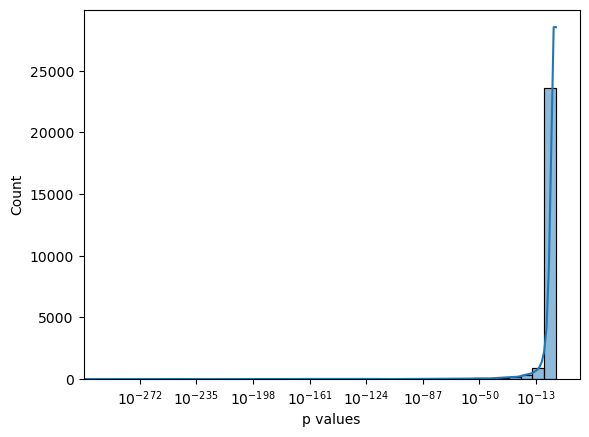

In [443]:
ax = sn.histplot(pvals[pvals!=0], bins=40, kde=True, log_scale=True)
plt.xlabel('p values')

Too many eQTLs have a p-value of 0 to plot all of them

In [448]:
np.sum(pvals==0)

102

Therefore, selected not only the p-value of 0, but also high t-values.

In [472]:
np.sum(np.logical_and(pvals==0, np.abs(tvals)>50)) # ---> Filter for plotting

69

In [473]:
selected_snps = np.where(np.logical_and(pvals==0, np.abs(tvals)>50))[0]

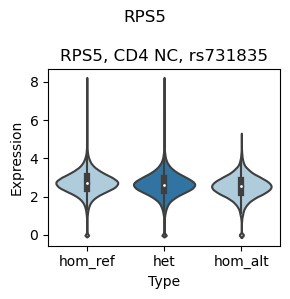

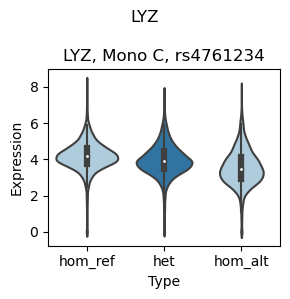

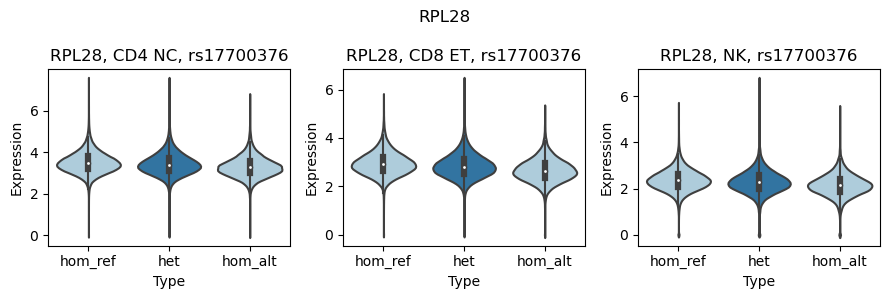

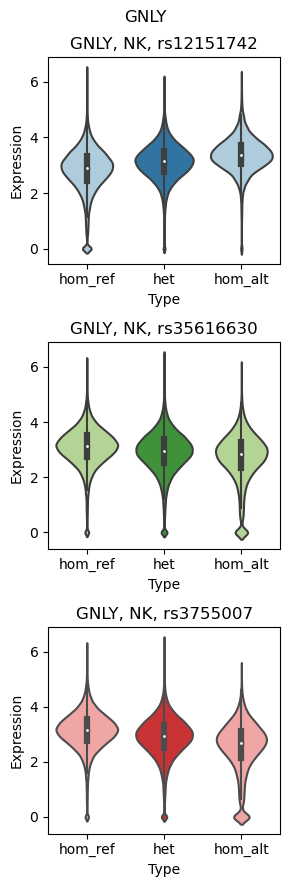

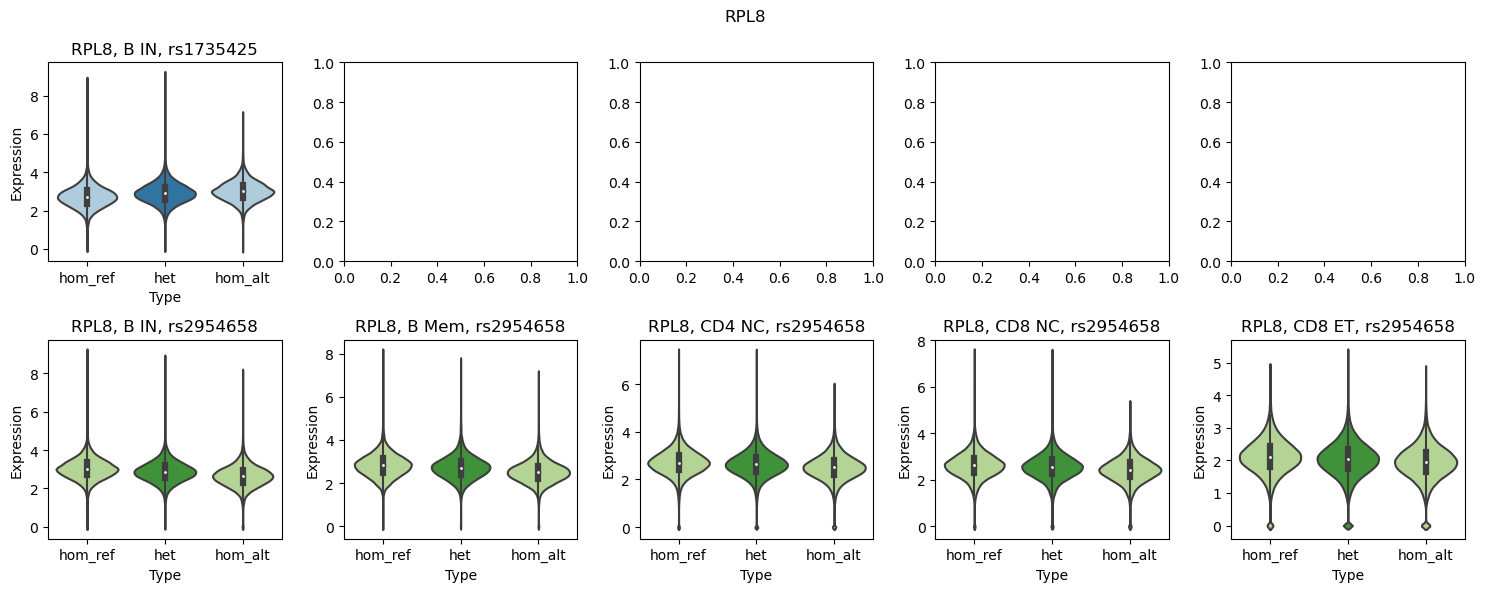

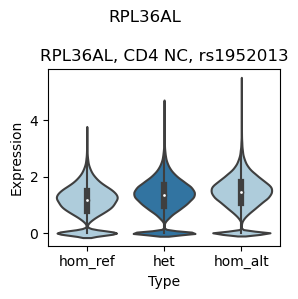

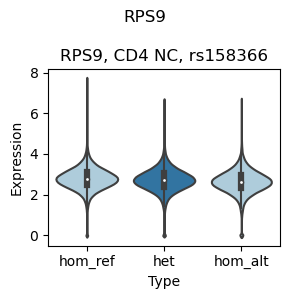

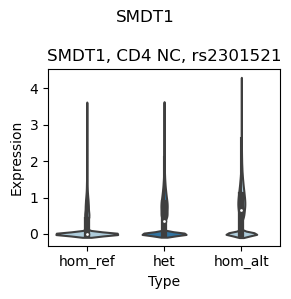

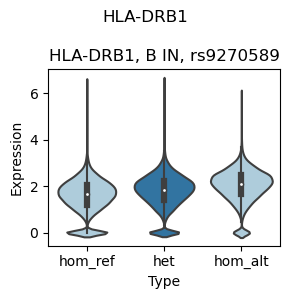

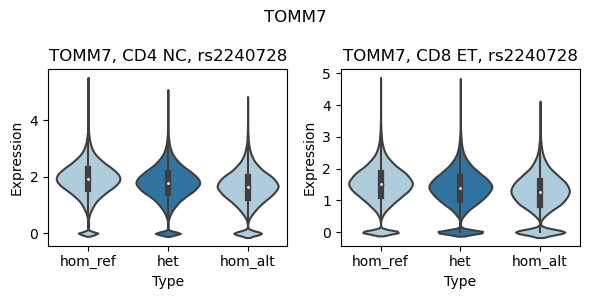

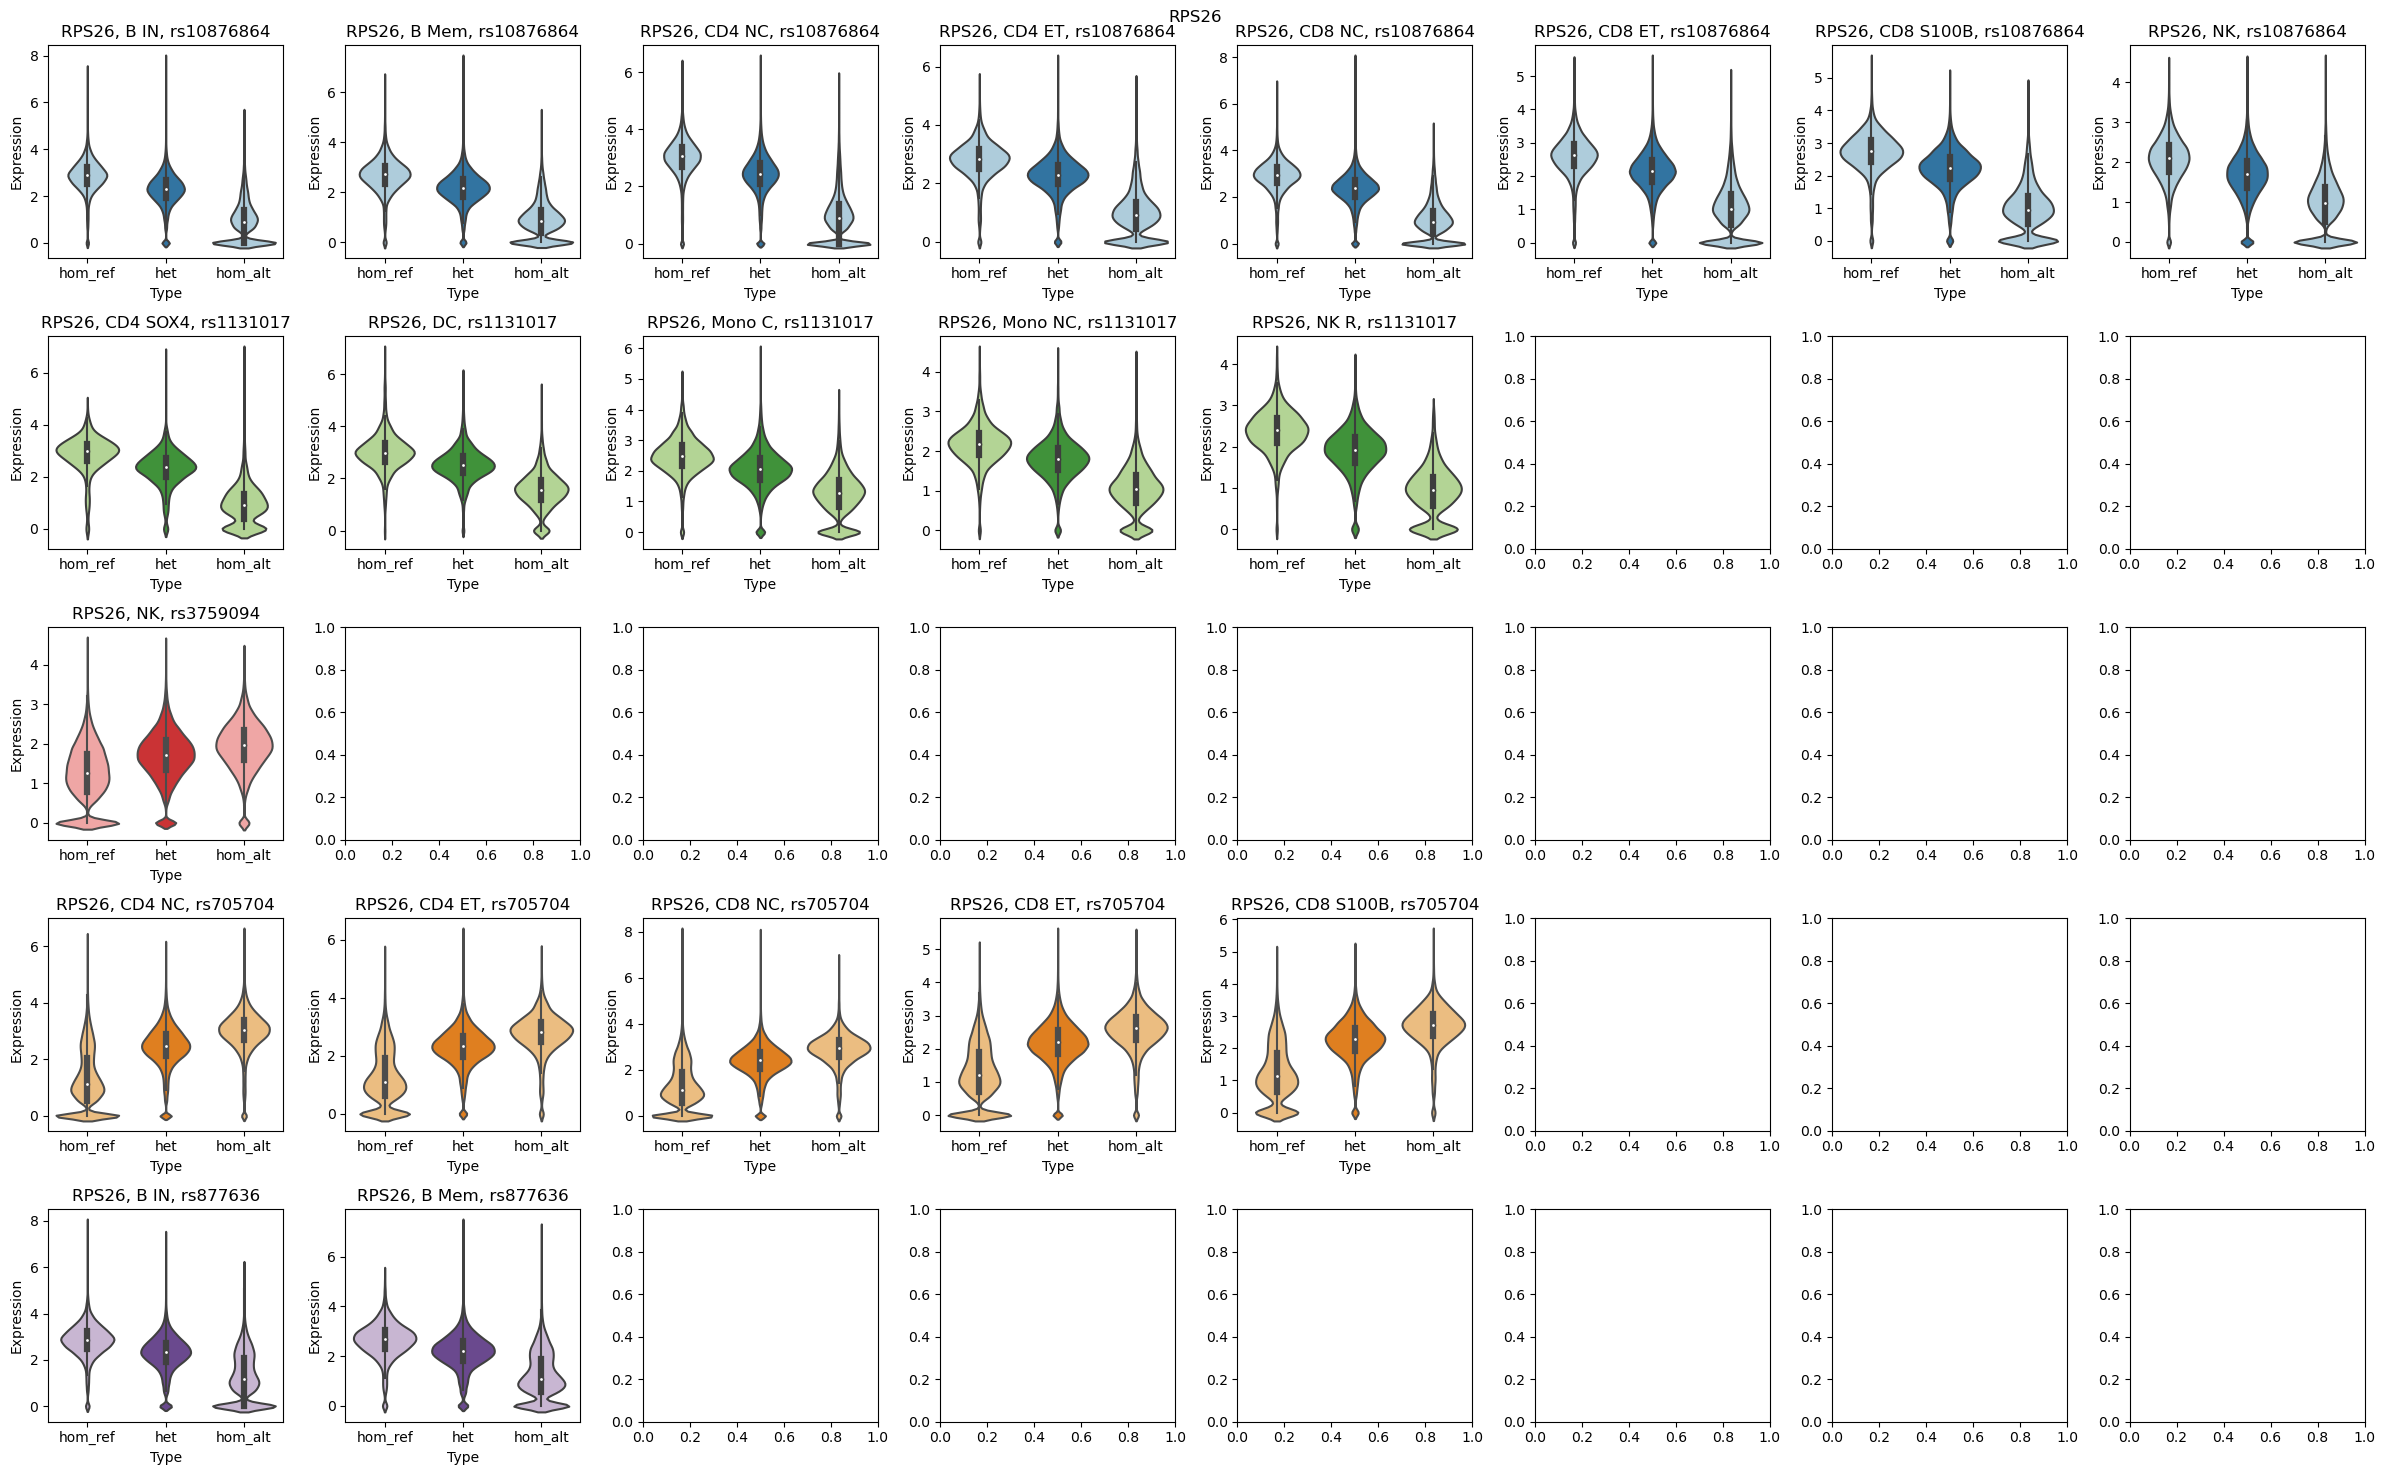

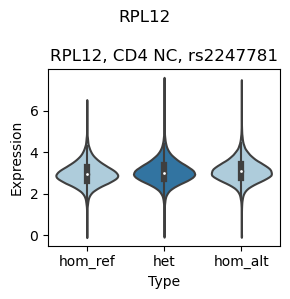

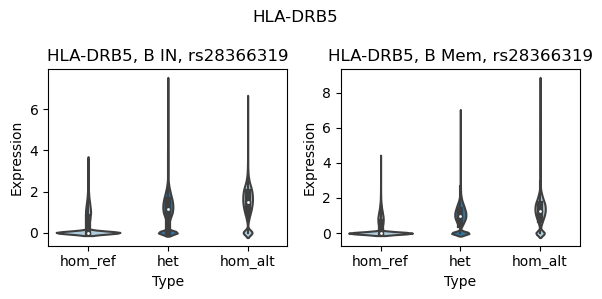

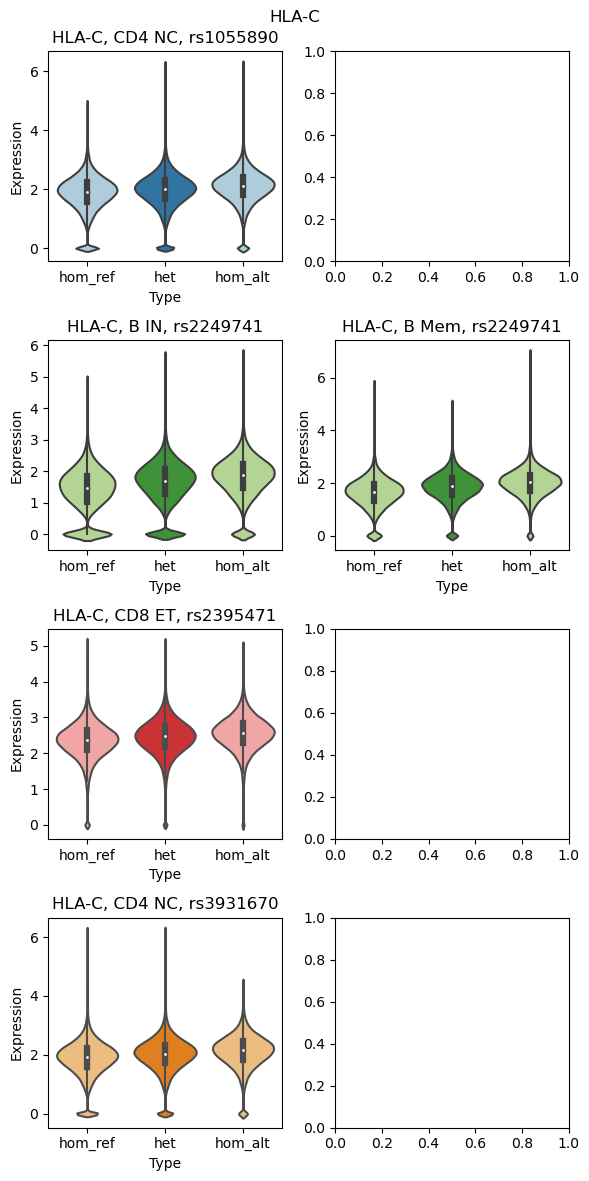

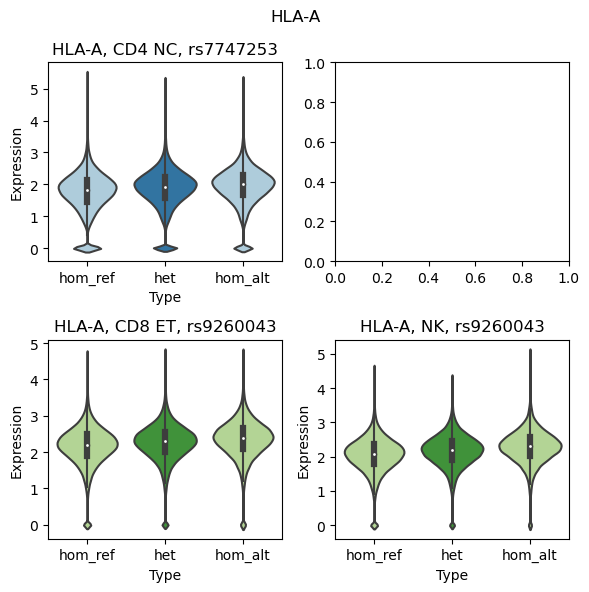

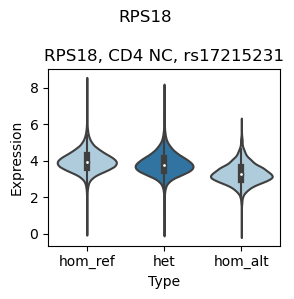

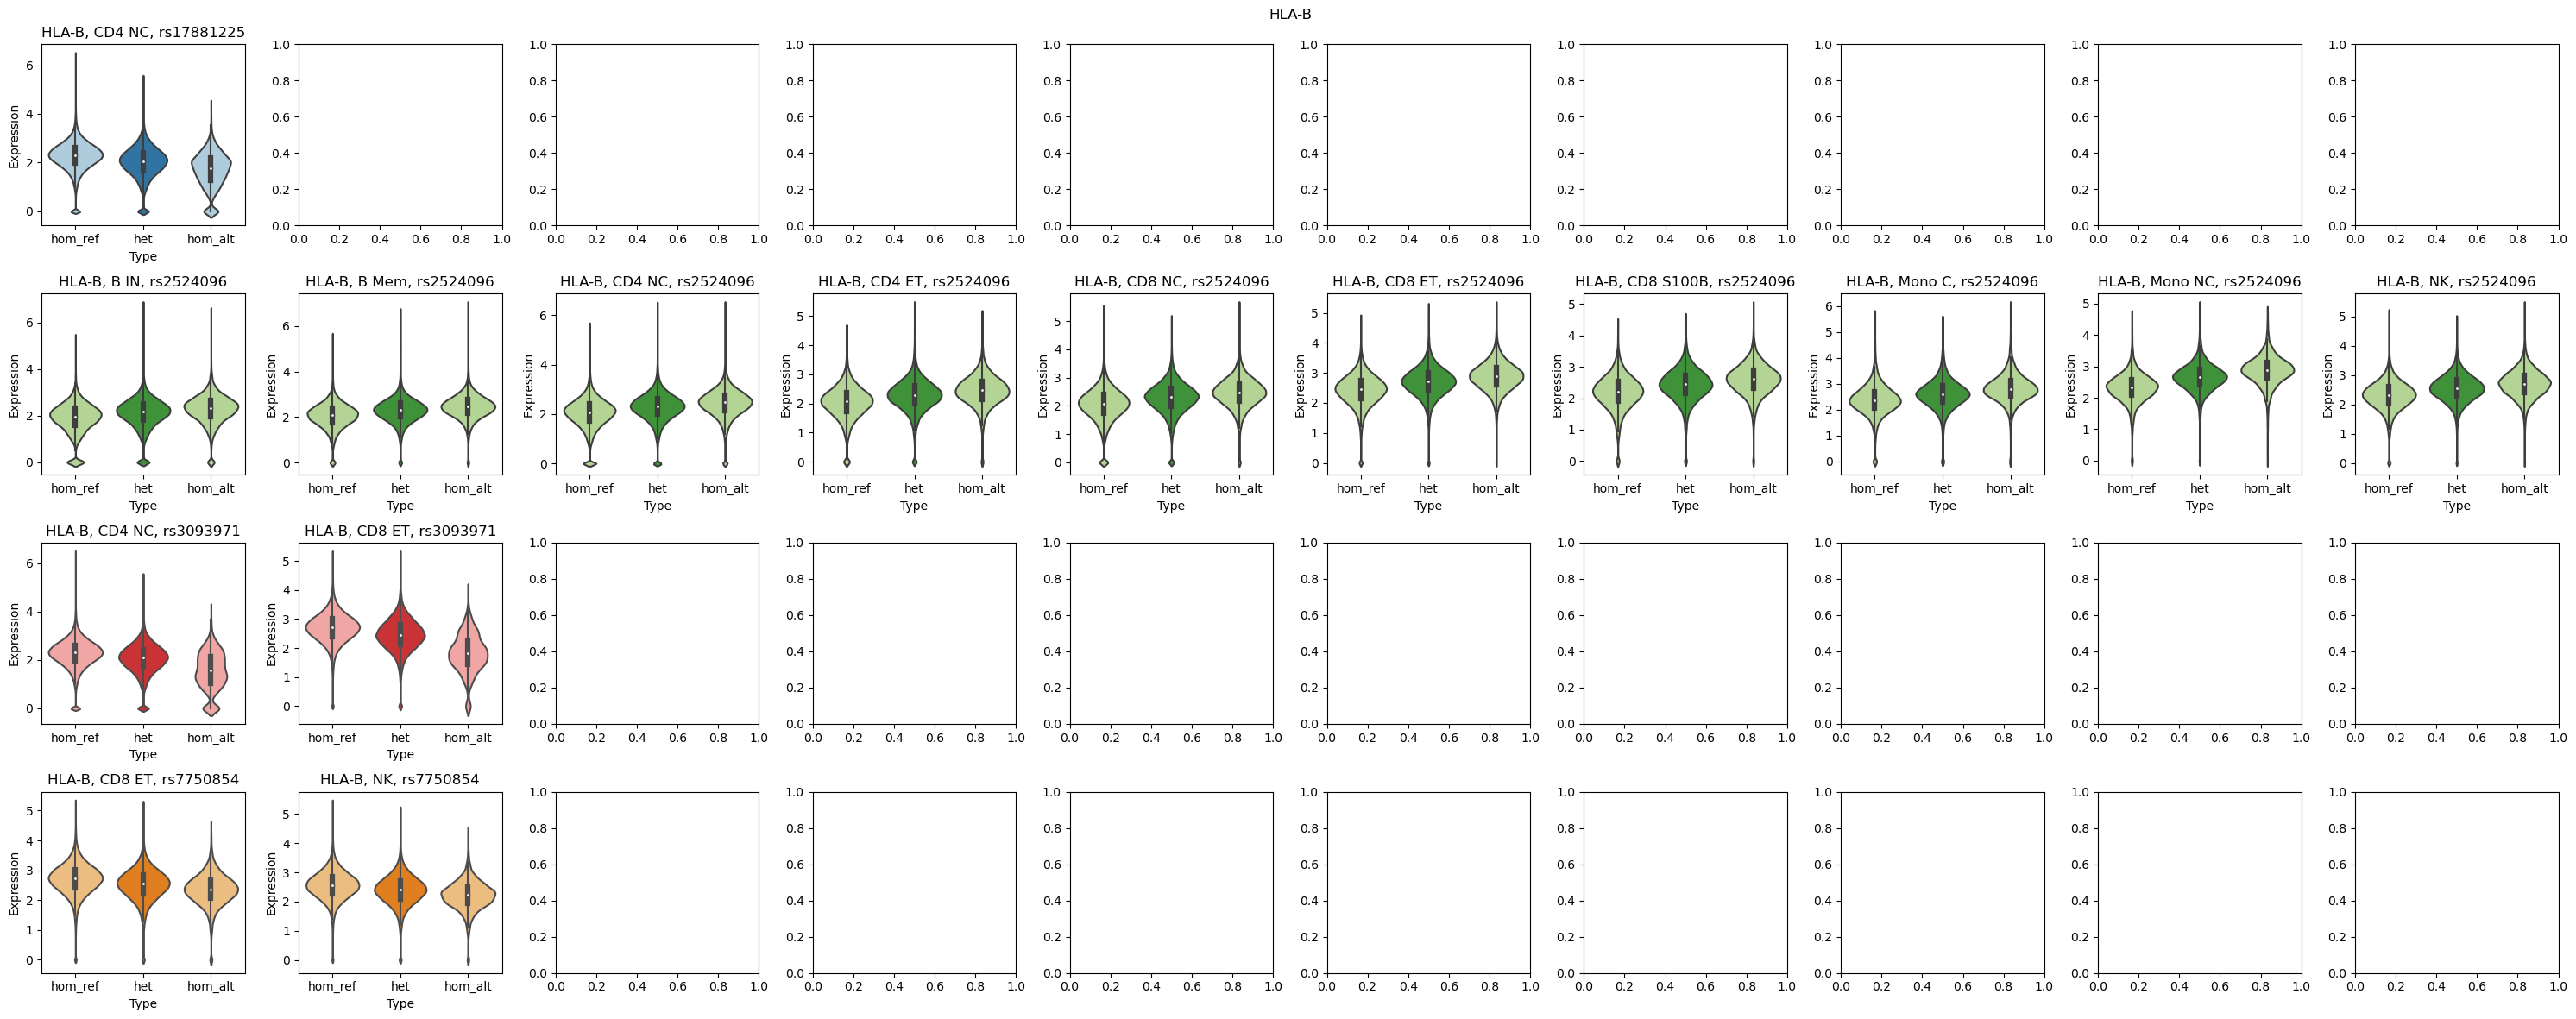

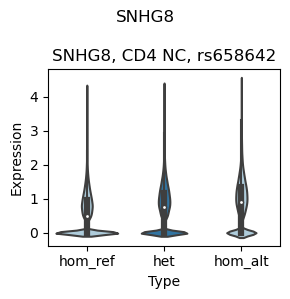

In [474]:
for gene in np.unique(eqtl.loc[selected_snps, :]['Gene Ensembl ID']):
    plot_by_gene(gene, selected_snps)

Facts about SNHG8:
- Moreover, the knockdown of SNHG8 reduced the expression of Ki-67, proliferating cell nuclear antigen (PCNA), and Bcl-2 and enhanced the expression of Bax and cleaved caspase 3/9. MiR-335-5p was predicted to be a potential target of SNHG8 by using the bioinformatics analysis, and the interaction between the two was validated by using the dual luciferase assay. In addition, the knockdown of SNHG8 increased the level of miR-335-5p, whereas miR-335-5p mimic decreased the expression of SNHG8. 
- Taken together, our study suggests that lncRNA SNHG8 exerts a cancer-promoting effect on DLBCL via targeting miR-335-5p. (https://www.frontiersin.org/articles/10.3389/fonc.2021.650287/full)